# Libraries




In [ ]:
import os
import numpy as np
import pandas as pd

import cv2
import skimage as ski
from PIL import Image, ImageDraw
from io import BytesIO

from pathlib import Path

import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
from matplotlib.colors import to_hex
import matplotlib.patches as mpatches
import matplotlib
import plotly

from sklearn.decomposition import PCA
from sklearn.metrics import auc
from sklearn.preprocessing import StandardScaler
import sklearn as skl

import warnings
from tqdm.auto import tqdm

from scipy.cluster.hierarchy import linkage, leaves_list, fcluster,dendrogram
from scipy.stats import gaussian_kde
from scipy import ndimage

import seaborn as sns

import umap.umap_ as umap

from google.colab import drive
drive.mount('/content/gdrive')
path="/content/gdrive/MyDrive/these/"


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%pip install pacmap
from pacmap import PaCMAP
import pacmap

# Meta-clustering

In [ ]:

bool_exist=False
while bool_exist==False:
 path = "/content/gdrive/MyDrive/"
 name_path = input("Enter the path where the project has been be created: ")
 path += name_path + "/"
 bool_exist=os.path.isdir(path)
 if bool_exist==False:
   print("❌ The path does not exist")
 else:
  print("✅ Project :"+path)
  bool_exist=True

path_img_raw=path+"images/raw/"
path_mask_cell=path+"segmentation/segmentation_cells/mask/"
path_clust=path+"clustering/"
path_clust_mfi=path_clust+"MFI/"
path_segmentation_df=path+"segmentation/segmentation_cells/df_ROI/"
path_main_clust=path_clust+"main_clustering/"

if os.path.isdir(path_img_raw)==False:
   print("❌ You have not completed the step of creating PNG images")
elif os.path.isdir(path_mask_cell)==False:
   print("❌ You have not completed the step of cells segmentation")
elif os.path.isdir(path_clust_mfi)==False:
   print("❌ You have not completed the step of calcul of MFI")
elif os.path.isdir(path_main_clust)==False:
   print("❌ You have not completed the step of clustering the main phenotypes")

pheno=input("Enter the phenotype from which you want to determine the subpopulations: ")
path_subpop=path_clust+pheno+"/"
if os.path.isdir(path_subpop)==False:
  os.mkdir(path_subpop)
  print(f"✅ The files concerning the clustering of {pheno} subpopulations can be found in the following folder:  {path_subpop}")


Enter the path where the project has been be created: these/pipeline/rejection
✅ Project :/content/gdrive/MyDrive/these/pipeline/rejection/
Enter the phenotype from which you want to determine the subpopulations: LT4


### Selection of markers used to define the subpopulations

In [ ]:
list_marker=input(f"Enter the markers used to define the different {pheno} subpopulations (separated by a comma):").split(",")

Enter the markers used to define the different LT4_TBET subpopulations (separated by a comma):HLADR,CD45RA,CD69,Foxp3,PD-1,CCR7,CD57,Tbet,CXCR5


In [ ]:
df_pheno=pd.read_csv(path_clust+"main_clustering/mfi_pheno.csv")
df_mfi_tot=pd.read_csv(path_clust+"mfi_corrected_arcsinh_std.csv")
df_subpop=df_mfi_tot.copy()
df_subpop=df_subpop[list_marker]
df_subpop["phenotype"]=df_pheno["phenotype"]
df_subpop["ROI"]=df_pheno["ROI"]
df_subpop["coord"]=df_pheno["coord"]
df_subpop["Cell_ID"]=df_pheno["Cell_ID"]
df_subpop=df_subpop.loc[(df_subpop.loc[:,"phenotype"]==pheno)]
df_subpop=df_subpop.drop(["phenotype"],axis=1)
df_subpop.to_csv(path_subpop+"mfi_"+pheno+"_subpop.csv",index=False)
print(f"✅ The dataframe with all the {pheno} cells and the markers used to define the subpopulations can be found there:  {path_subpop+"mfi_"+pheno+"_subpop.csv"}")
df_subpop_num=df_subpop.drop(["coord","ROI","Cell_ID"],axis=1)
print(df_subpop.shape)
df_subpop.columns

✅ The dataframe with all the LT4 cells and the markers used to define the subpopulations can be found there:  /content/gdrive/MyDrive/these/pipeline/rejection/clustering/LT4/mfi_LT4_subpop.csv
(3953, 12)


Index(['HLADR', 'CD45RA', 'CD69', 'Foxp3', 'PD-1', 'CCR7', 'CD57', 'Tbet',
       'CXCR5', 'ROI', 'coord', 'Cell_ID'],
      dtype='object')

### Visualization of the markers among the phenotype



In [ ]:
df_subpop_num=pd.read_csv(path_subpop+"mfi_"+pheno+"_subpop.csv")
df_subpop_num=df_subpop_num.drop(["Cell_ID","ROI","coord"],axis=1)
df_subpop_num.head()

HLADR    CD45RA      CD69     Foxp3      PD-1      CCR7      CD57  \
0  0.379393  0.776029 -0.296844 -0.124624 -0.855866  0.349559 -0.403489   
1 -0.533756 -0.081900 -0.282423  0.131361  0.882198  0.713513 -0.334773   
2 -0.280085 -0.742098 -0.629219 -0.686033 -0.115305 -0.846396  0.918152   
3 -0.217788  0.607424 -0.269207  0.785096 -0.115305  1.146757 -0.415324   
4 -0.503085 -0.081900 -0.770386 -0.692139 -0.855866 -0.846396 -0.788043   

       Tbet     CXCR5  
0  0.185720  0.450745  
1  0.510867  0.572436  
2  0.185720 -0.015882  
3  0.007631 -0.482676  
4  2.597996 -0.036175

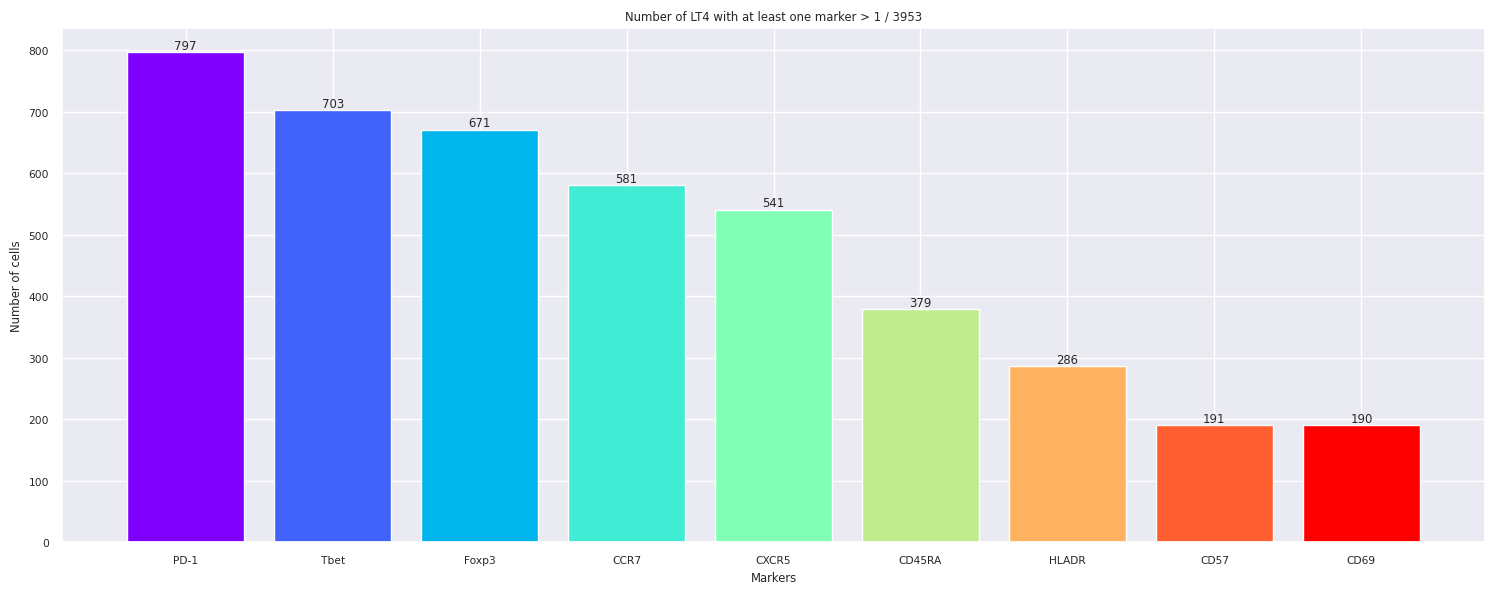

In [ ]:
sns.set(font_scale=0.7)
thresh = 1
counts = (df_subpop_num > thresh).sum()

# Sort counts in descending order
counts_sorted = counts.sort_values(ascending=False)

# Create a list of colors
colors = plt.cm.rainbow(np.linspace(0, 1, len(counts_sorted)))

# Create the bar plot
plt.figure(figsize=(15, 6))
bars = plt.bar(counts_sorted.index, counts_sorted.values, color=colors)
plt.title("Number of "+pheno+" with at least one marker > " + str(thresh) + " / " + str(df_subpop.shape[0]))
plt.xlabel("Markers")
plt.ylabel("Number of cells")
plt.xticks(rotation=0)

# Add values above bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2., height,
        f'{height}',
        ha='center', va='bottom'
    )

plt.tight_layout()
plt.savefig(path_subpop + "main_markers_" + pheno + ".png")
plt.show()


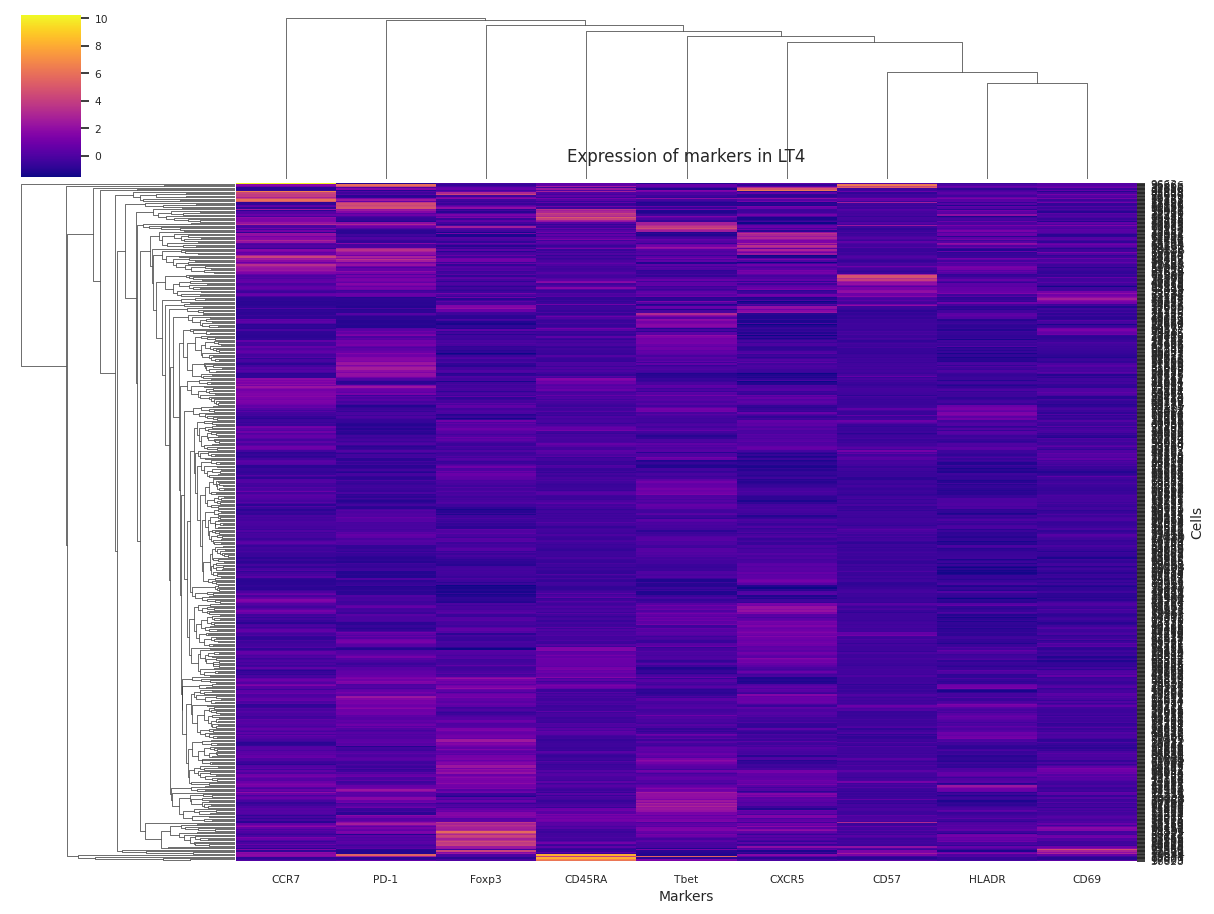

In [ ]:
df_sample = df_subpop_num.sample(500)

g = sns.clustermap(
    df_sample,
    xticklabels=True,
    yticklabels=True,
    cmap='plasma',
    figsize=(12, 9)
)

# Set titles on the heatmap axis (not the global plt axes)
g.ax_heatmap.set_title(f"Expression of markers in {pheno}", fontsize=12, pad=15)
g.ax_heatmap.set_xlabel("Markers", fontsize=10)
g.ax_heatmap.set_ylabel("Cells", fontsize=10)

# Save figure
g.fig.savefig(path_subpop + "heatmap_cells.png", dpi=300, bbox_inches="tight")
plt.show()


### Clustering using the markers selected by Hierarchical clustering algorithm (Ward)
The goal is to determine the ideal number of clusters that best reflects the presence of major subpopulations within the phenotype being studied.

#### Functions

In [ ]:

def ward_clustering_umap(
    X,
    marker_names=None,
    min_k=2,
    max_k=10,
    standardize=True,
    method="ward",
    outdir=None,
    heatmap_cmap="viridis",
    pca_points_size=6,      # point size for UMAP scatter
    umap_n_neighbors=15,
    umap_min_dist=0.1,
    umap_metric="euclidean",
    umap_random_state=42,
):
    """
    Publication-ready Ward clustering visualization using UMAP.

    For each number of clusters k in [min_k, max_k], this function creates
    a single-row figure with four panels:
        1. Left: horizontal bar plot of cluster sizes (bars extend to the LEFT).
        2. Center-left: heatmap of average marker expression per cluster (+ annotations).
        3. Center-right: Ward dendrogram with branches colored by cluster
           (same colors as the UMAP scatter).
        4. Right: 2D UMAP projection with clusters in different colors.
    """

    # ---------- Convert to array ----------
    X = np.asarray(X)
    n_cells, n_markers = X.shape

    if marker_names is None:
        marker_names = [f"marker_{i}" for i in range(n_markers)]

    # ---------- Style (publication-ish) ----------
    sns.set_context("talk", font_scale=0.8)
    sns.set_style("whitegrid", {'axes.grid': False})

    # ---------- Standardization ----------
    if standardize:
        scaler = StandardScaler()
        X_proc = scaler.fit_transform(X)
    else:
        X_proc = X

    # ---------- Hierarchical clustering (Ward) ----------
    Z = linkage(X_proc, method=method)

    # Precompute members for each node in the tree (needed for coloring links)
    # Leaves: 0..n_cells-1, internal nodes: n_cells..n_cells+n_cells-2
    cluster_members = {i: np.array([i], dtype=int) for i in range(n_cells)}
    for node_id in range(n_cells, n_cells + n_cells - 1):
        row = node_id - n_cells
        left = int(Z[row, 0])
        right = int(Z[row, 1])
        members = np.concatenate([cluster_members[left], cluster_members[right]])
        cluster_members[node_id] = members

    # ---------- UMAP for visualization ----------
    reducer = umap.UMAP(
        n_neighbors=umap_n_neighbors,
        min_dist=umap_min_dist,
        metric=umap_metric,
        random_state=umap_random_state,
    )
    X_2d = reducer.fit_transform(X_proc)

    # ---------- Output dir ----------
    if outdir is not None:
        os.makedirs(outdir, exist_ok=True)

    # ---------- Loop over k ----------
    for k in range(min_k, max_k + 1):

        labels = fcluster(Z, t=k, criterion="maxclust")  # cluster labels (1..k en général)

        # Mean marker expression per cluster
        df_tmp = pd.DataFrame(X, columns=marker_names)
        df_tmp["cluster"] = labels
        mean_expr = df_tmp.groupby("cluster")[marker_names].mean()

        # Cluster sizes
        cluster_sizes = df_tmp["cluster"].value_counts().sort_index()

        # Ensure ordering of clusters
        mean_expr = mean_expr.loc[cluster_sizes.index]
        cluster_sizes_ordered = cluster_sizes.loc[mean_expr.index]
        n_clusters_k = mean_expr.shape[0]

        # ---------- Color mapping: cluster id -> color ----------
        cmap_clusters = plt.get_cmap("tab20", n_clusters_k)
        cluster_ids = list(mean_expr.index)  # e.g. [1, 2, ..., k]

        cluster_to_color = {
            cid: cmap_clusters(i)
            for i, cid in enumerate(cluster_ids)
        }

        # Colors for each cell (for UMAP scatter)
        point_colors = [cluster_to_color[cid] for cid in labels]

        # Colors for each node in the dendrogram
        node_color = {}
        for node_id, members in cluster_members.items():
            cluster_ids_node = np.unique(labels[members])
            if len(cluster_ids_node) == 1:
                # Node belongs entirely to a single flat cluster: use that cluster color
                rgb = cluster_to_color[cluster_ids_node[0]]
                node_color[node_id] = to_hex(rgb)   # convert RGBA -> hex string
            else:
                # Mixed node: neutral gray
                node_color[node_id] = "#808080"

        def link_color_func(node_id: int):
            # node_id is the index of a leaf or internal node (0..)
            return node_color.get(node_id, "#808080")

        # ---------- Figure layout ----------
        fig = plt.figure(
            figsize=(8 + 0.5 * n_markers, 4),
            constrained_layout=True
        )

        gs = fig.add_gridspec(
            1, 4,
            width_ratios=[0.45, 1.8, 1.6, 2.1],
            wspace=0.02
        )

        ax_bar = fig.add_subplot(gs[0, 0])
        ax_hm  = fig.add_subplot(gs[0, 1])
        ax_den = fig.add_subplot(gs[0, 2])
        ax_sc  = fig.add_subplot(gs[0, 3])

        # ============================================================
        # 1) BARPLOT (cluster sizes, left-oriented, glued to heatmap)
        # ============================================================
        y_positions = np.arange(n_clusters_k)
        counts = cluster_sizes_ordered.values
        max_count = counts.max()

        ax_bar.barh(
            y_positions,
            counts,
            color="0.6"
        )

        ax_bar.invert_yaxis()
        ax_bar.invert_xaxis()

        # Clean visuals
        for spine in ax_bar.spines.values():
            spine.set_visible(False)
        ax_bar.set_xticks([])
        ax_bar.set_yticks([])

        # Extend x-limit so text fits on far left
        ax_bar.set_xlim(max_count * 1.25, 0)

        # Text labels LEFT of bar
        for y, val in zip(y_positions, counts):
            ax_bar.text(
                max_count * 1.23,
                y,
                str(val),
                ha="right",
                va="center",
                fontsize=9
            )

        ax_bar.set_xlabel("Cells", fontsize=9, labelpad=4)

        # ============================================================
        # 2) HEATMAP (with annotations)
        # ============================================================
        annot_values = np.round(mean_expr.values, 2)

        sns.heatmap(
            mean_expr,
            ax=ax_hm,
            cmap=heatmap_cmap,
            cbar=True,
            xticklabels=marker_names,
            yticklabels=[f"C{c}" for c in mean_expr.index],
            cbar_kws={"shrink": 0.7},
            annot=annot_values,
            fmt="",
            annot_kws={"fontsize": 7}
        )

        ax_hm.set_title(f"Average marker expression – {k} clusters", fontsize=11, pad=8)
        ax_hm.set_xlabel("Markers", fontsize=9)
        ax_hm.set_ylabel("Cluster", fontsize=9)

        ax_hm.yaxis.tick_right()
        ax_hm.yaxis.set_label_position("right")
        ax_hm.tick_params(axis="both", labelsize=8)

        # ============================================================
        # 3) DENDROGRAM + cut line, colored by flat clusters
        # ============================================================
        dendrogram(
            Z,
            ax=ax_den,
            no_labels=True,
            color_threshold=None,
            link_color_func=link_color_func
        )
        ax_den.set_title("Dendrogram (Ward)", fontsize=11, pad=8)
        ax_den.set_xlabel("Cells", fontsize=9)
        ax_den.set_ylabel("Distance", fontsize=9)
        ax_den.tick_params(axis="both", labelsize=8)

        # Add horizontal cut for k clusters
        if 1 <= k <= n_cells - 1:
            cut_height = Z[n_cells - k - 1, 2]
            ax_den.axhline(y=cut_height, color="red", linestyle="--", linewidth=1)
            ax_den.text(
                0.02,
                cut_height,
                f"k = {k}",
                color="red",
                fontsize=8,
                va="bottom",
                ha="left",
                transform=ax_den.get_yaxis_transform()
            )

        # ============================================================
        # 4) UMAP SCATTER (cluster-colored, same colors as dendrogram)
        # ============================================================
        scatter = ax_sc.scatter(
            X_2d[:, 0],
            X_2d[:, 1],
            c=point_colors,
            s=pca_points_size,
            edgecolor="none",
            alpha=0.9
        )

        ax_sc.set_title("UMAP 2D", fontsize=11, pad=8)
        ax_sc.set_xlabel("UMAP 1", fontsize=9)
        ax_sc.set_ylabel("UMAP 2", fontsize=9)
        ax_sc.tick_params(axis="both", labelsize=8)

        # Legend using cluster_to_color mapping
        legend_handles = [
            Patch(color=cluster_to_color[cid], label=f"C{cid}")
            for cid in cluster_ids
        ]
        ax_sc.legend(
            handles=legend_handles,
            title="Clusters",
            fontsize=8,
            title_fontsize=9,
            frameon=False,
            loc="best"
        )

        # ============================================================
        # Title (with spacing)
        # ============================================================
        fig.suptitle(
            f"Ward clustering (k = {k})",
            fontsize=13,
            y=1.07,
        )

        # ============================================================
        # SAVE FIGURE
        # ============================================================
        if outdir is not None:
            fname = os.path.join(outdir, f"ward_umap_panels_k{k}.png")
            fig.savefig(fname, dpi=300, bbox_inches="tight")
            print(f"✅ The files concerning the heatmap of {pheno} subpopulations can be found in the following folder:  {path_heatmap_subpop}")


        plt.show()


In [ ]:
from scipy.cluster.hierarchy import linkage, fcluster

def assign_clusters_ward(df, marker_cols, k=5):
    X = df[marker_cols].values

    scaler = StandardScaler()
    X_proc = scaler.fit_transform(X)

    Z = linkage(X_proc, method="ward")

    labels = fcluster(Z, t=k, criterion="maxclust")
    df["cluster"] = labels

    print(f"Clusters assigned (k = {k})")
    print(df["cluster"].value_counts().sort_index())

    return df, labels



#### Hierarchical clustering using the Ward method

In [ ]:
path_heatmap_subpop=path_subpop+"Agglomerative_hierarchical_clustering"
if os.path.isdir(path_heatmap_subpop)==False:
  os.mkdir(path_heatmap_subpop)
  print(f"✅ The files concerning the heatmap of {pheno} subpopulations can be found in the following folder:  {path_heatmap_subpop}")

In [ ]:
df_subpop_num=pd.read_csv(path_subpop+"mfi_"+pheno+"_subpop.csv")
df_subpop_num=df_subpop_num.drop(["Cell_ID","ROI","coord"],axis=1)
df_subpop_num.head()

HLADR    CD45RA      CD69     Foxp3      PD-1      CCR7      CD57  \
0  0.379393  0.776029 -0.296844 -0.124624 -0.855866  0.349559 -0.403489   
1 -0.533756 -0.081900 -0.282423  0.131361  0.882198  0.713513 -0.334773   
2 -0.280085 -0.742098 -0.629219 -0.686033 -0.115305 -0.846396  0.918152   
3 -0.217788  0.607424 -0.269207  0.785096 -0.115305  1.146757 -0.415324   
4 -0.503085 -0.081900 -0.770386 -0.692139 -0.855866 -0.846396 -0.788043   

       Tbet     CXCR5  
0  0.185720  0.450745  
1  0.510867  0.572436  
2  0.185720 -0.015882  
3  0.007631 -0.482676  
4  2.597996 -0.036175

In [ ]:
k_max=int(input(f"Enter the maximum number of {pheno} subpopulations:"))

Enter the maximum number of LT4 subpopulations:15


In [ ]:

X = df_subpop_num.values
marker_names = df_subpop_num.columns.tolist()

ward_clustering_umap(
    X,
    marker_names=marker_names,
    min_k=2,
    max_k=k_max,
    outdir=path_heatmap_subpop,
    heatmap_cmap="magma",
    umap_n_neighbors=15,
    umap_min_dist=0.1,
)


In [ ]:
k_final=int(input("Enter the best number of clusters to do the phenotype annotation: "))
marker_cols = df_subpop_num.columns.tolist()
df_cluster, labels = assign_clusters_ward(df_subpop, marker_cols, k=k_final)
df_cluster.to_csv(path_subpop+f"mfi_{pheno}_subpop_cluster.csv",index=False)
df_cluster.head()

Enter the best number of clusters to do the phenotype annotation: 12
Clusters assigned (k = 12)
cluster
1     1490
2      479
3       37
4      155
5      226
6      222
7       83
8      293
9      153
10     379
11     201
12     235
Name: count, dtype: int64


HLADR    CD45RA      CD69     Foxp3      PD-1      CCR7      CD57  \
119  0.379393  0.776029 -0.296844 -0.124624 -0.855866  0.349559 -0.403489   
143 -0.533756 -0.081900 -0.282423  0.131361  0.882198  0.713513 -0.334773   
191 -0.280085 -0.742098 -0.629219 -0.686033 -0.115305 -0.846396  0.918152   
208 -0.217788  0.607424 -0.269207  0.785096 -0.115305  1.146757 -0.415324   
226 -0.503085 -0.081900 -0.770386 -0.692139 -0.855866 -0.846396 -0.788043   

         Tbet     CXCR5         ROI  \
119  0.185720  0.450745  20U03813 a   
143  0.510867  0.572436  20U03813 a   
191  0.185720 -0.015882  20U03813 a   
208  0.007631 -0.482676  20U03813 a   
226  2.597996 -0.036175  20U03813 a   

                                                 coord  Cell_ID  cluster  
119  40,449;40,450;40,451;41,448;41,449;41,450;41,4...      119        8  
143  49,0;49,1;49,2;49,3;50,0;50,1;50,2;50,3;50,4;5...      143        1  
191  63,130;63,131;63,132;64,129;64,130;64,131;64,1...      191        1  
208  68,350;68,351;68,352;68,353;69,348;69,349;69,3...      208        1  
226  73,450;73,451;73,452;74,449;74,450;74,451;74,4...      226        2

### Heatmap of marker expression across clusters

#### Functions

In [ ]:
def heatmap_histo(df, name_value, title, path, threshold, vmin, vmax):

    sns.set(font_scale=1)

    # --- Data ---
    data = df.groupby(name_value).mean()
    counts = df[name_value].value_counts().sort_index()

    linkage_result = linkage(data, method="ward")
    order = leaves_list(linkage_result)
    data = data.iloc[order]
    counts = counts.iloc[order]

    n_clusters = len(data)
    fig = plt.figure(figsize=(10, max(6, n_clusters * 0.4)))
    fig.patch.set_facecolor('white')
    gs = GridSpec(nrows=1, ncols=2, width_ratios=[1.2, 5], wspace=0.02)

    # --- Histogram ---
    ax_bar = fig.add_subplot(gs[0])
    y_positions = [i + 0.5 for i in range(n_clusters)]

    bars = ax_bar.barh(
        y=y_positions,
        width=counts.values,
        height=1,
        color='gray'
    )

    # Add cell counts inside the histogram
    for y, count in zip(y_positions, counts.values):
        ax_bar.text(
            count - 1,
            y,
            str(count),
            va='center',
            ha='right',
            fontsize=8
        )

    ax_bar.set_yticks([])
    ax_bar.invert_xaxis()
    ax_bar.set_xlabel("")
    ax_bar.set_xticks([])
    ax_bar.xaxis.set_label_position('top')
    ax_bar.set_facecolor('none')
    ax_bar.yaxis.set_ticks_position('none')

    for spine in ['top', 'right', 'bottom']:
        ax_bar.spines[spine].set_visible(False)

    # --- NEW: Left-side legend for histogram ---
    ax_bar.set_ylabel("Number of cells", fontsize=11, labelpad=25, rotation=90)
    ax_bar.yaxis.set_label_position("left")

    # --- Heatmap ---
    ax_heatmap = fig.add_subplot(gs[1])
    heatmap = sns.heatmap(
        data,
        ax=ax_heatmap,
        vmin=vmin,
        vmax=vmax,
        cmap="vlag",
        linewidths=0.5,
        linecolor='gray',
        xticklabels=True,
        yticklabels=False,
        cbar=False
    )

    ax_heatmap.set_yticks([i + 0.5 for i in range(n_clusters)])
    ax_heatmap.set_yticklabels(data.index, fontsize=12)
    ax_heatmap.yaxis.tick_right()
    ax_heatmap.yaxis.set_label_position("right")

    # Align histogram with heatmap height
    ax_bar.set_ylim(ax_heatmap.get_ylim())

    # --- Red boxes above threshold ---
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            value = data.iloc[i, j]
            if value > threshold:
                rect = Rectangle((j, i), 1, 1, linewidth=2, edgecolor='red', facecolor='none')
                ax_heatmap.add_patch(rect)

    # --- Main title ---
    fig.suptitle(title, fontsize=16, y=1.05)

    # --- Colorbar above heatmap ---
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.cm as cm

    norm = plt.Normalize(vmin=data.values.min(), vmax=data.values.max())
    sm = plt.cm.ScalarMappable(cmap="vlag", norm=norm)
    sm.set_array([])

    cax = fig.add_axes([0.13, 0.94, 0.3, 0.015])
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=8)

    # --- Save ---
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig(path + f"Heatmap_{name_value}.png", bbox_inches='tight')
    plt.show()


#### Execution

/tmp/ipython-input-1685430397.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.93])


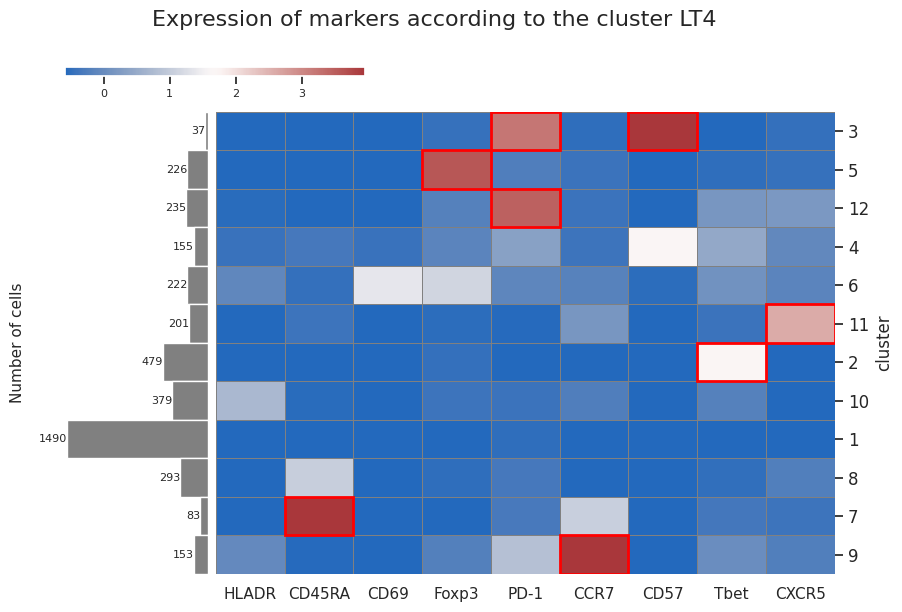

In [ ]:
df_subpop_cluster = pd.read_csv(path_subpop+"mfi_"+pheno+"_subpop_cluster.csv")
df_subpop_cluster_marker = df_subpop_cluster.drop(["Cell_ID", "ROI", "coord"], axis=1)

heatmap_histo(df_subpop_cluster_marker,"cluster","Expression of markers according to the cluster "+pheno,path_subpop,threshold=1.5,vmin=0,vmax=3)


### Distribution of the clusters across the different biopsies



In [ ]:
path_clust_roi=path_subpop+"proportion_cluster_roi/"
if os.path.isdir(path_clust_roi)==False:
  os.mkdir(path_clust_roi)

In [ ]:
df_subpop_cluster=pd.read_csv(path_subpop+"mfi_"+pheno+"_subpop_cluster.csv")

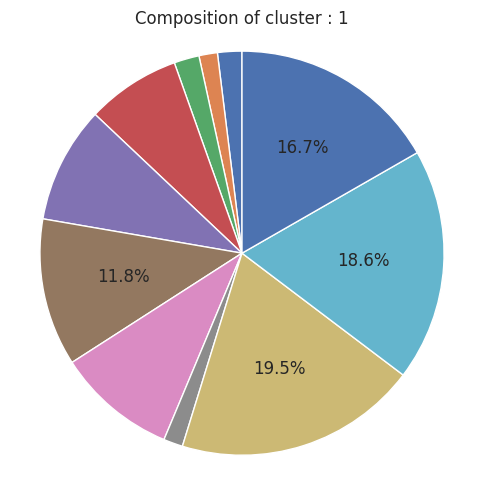

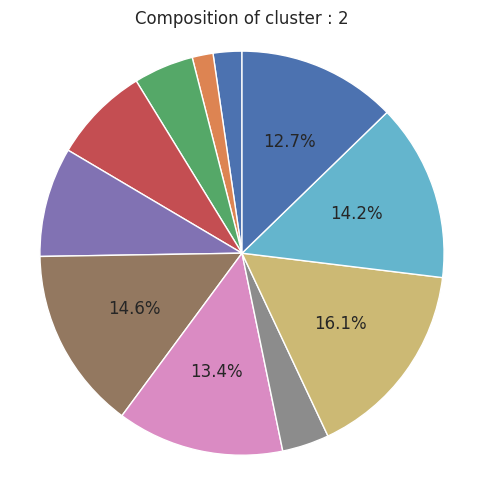

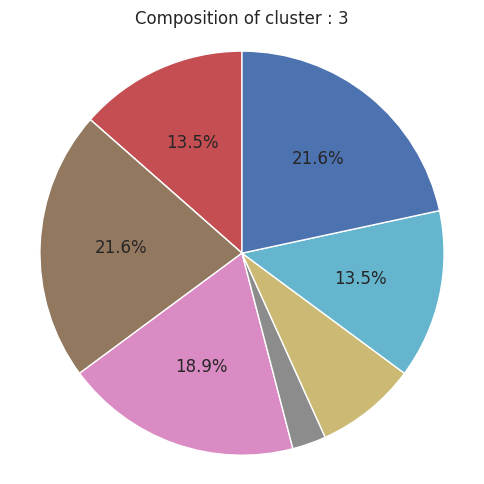

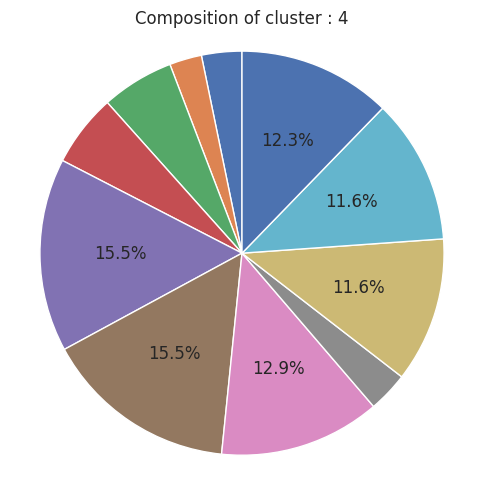

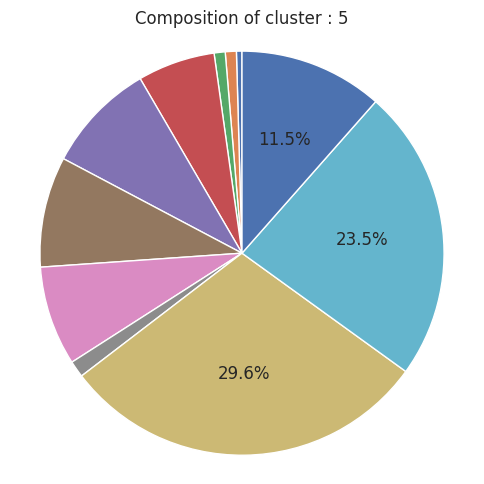

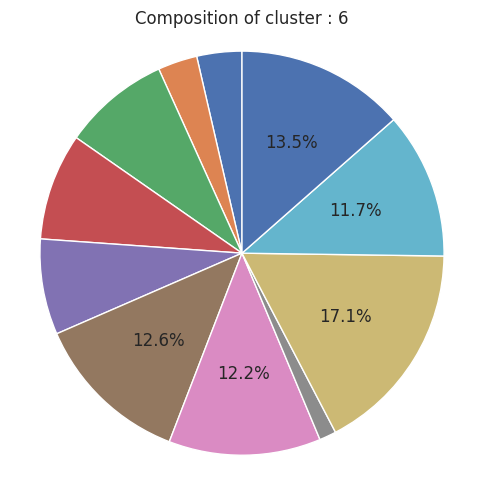

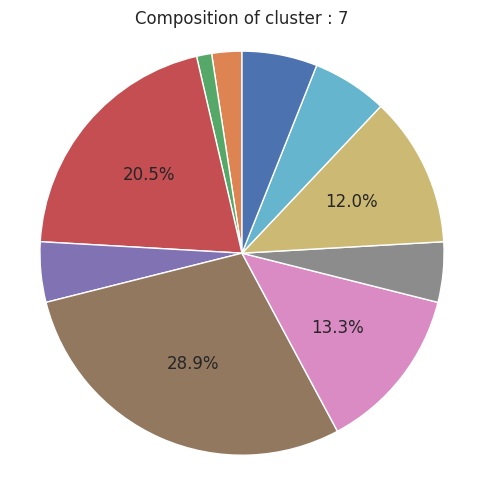

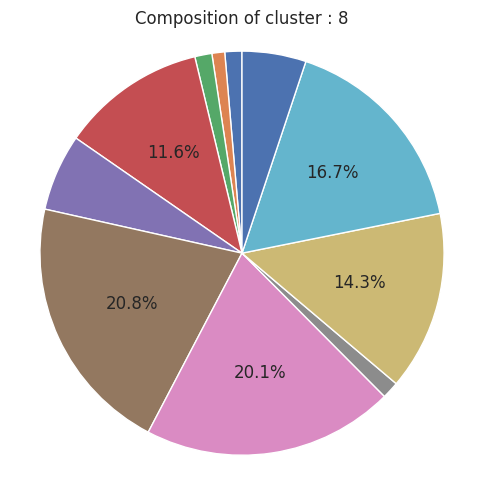

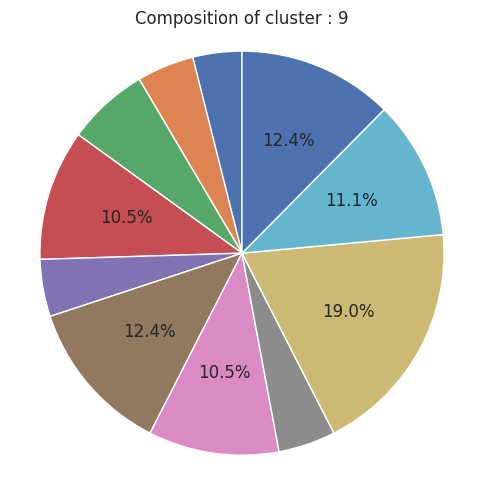

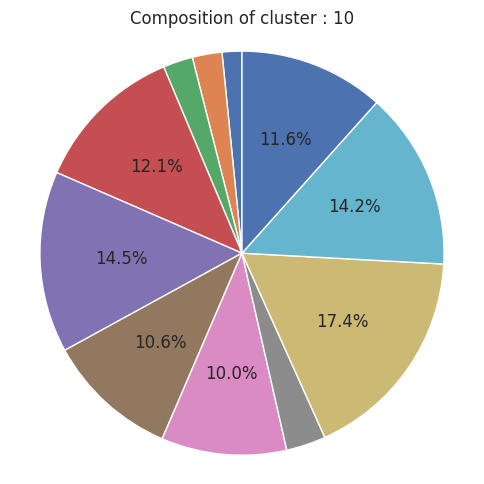

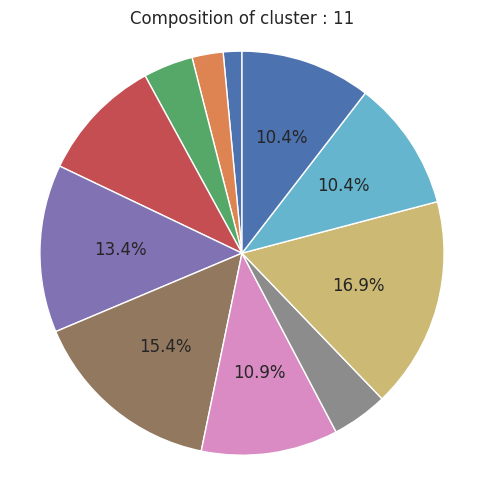

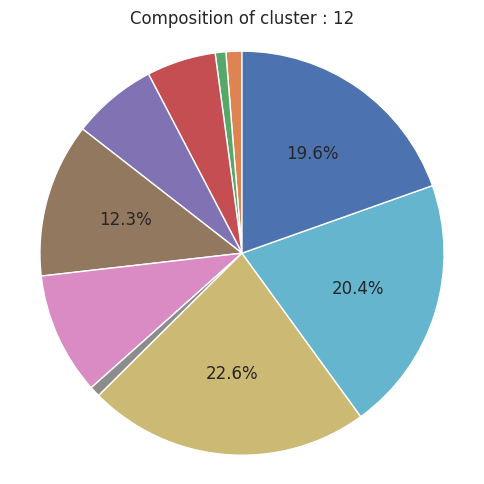

In [ ]:

patients_df = df_subpop_cluster[['cluster',"ROI"]]
grouped = patients_df.groupby('cluster')['ROI'].value_counts().unstack(fill_value=0)

def show_if_gt_10(pct):
    return f'{pct:.1f}%' if pct > 10 else ''

for group, row in grouped.iterrows():
    labels = row.index
    sizes = row.values

    plt.figure(figsize=(5, 5))
    plt.pie(sizes,autopct=show_if_gt_10, startangle=90)
    plt.title(f"Composition of cluster : {group}")
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig(path_clust_roi+"pie_chart_cluster_"+str(group)+".png")
    plt.show()


### Dotplot coexpression of markers within the clusters

#### Functions

In [ ]:

def plot_density_df(df, marker_x, marker_y, path_out, pheno,
                    palette='tab10',
                    x_thresh=None, y_thresh=None):
    """
    Plots the 2D density of a pair of markers and adds:
      - Red threshold lines (x_thresh, y_thresh)
      - A summary of counts and percentages:
        X+, Y+, double+, double-
    """

    plt.figure(figsize=(8, 6))
    x = df[marker_x].values
    y = df[marker_y].values

    # Compute local density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort points so that denser points appear on top
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    # Scatter plot colored by density
    sc = plt.scatter(x, y, c=z, cmap='viridis', s=3,
                     edgecolor='none', alpha=0.7)

    # 2D density contour lines
    sns.kdeplot(x=x, y=y, levels=5, linewidths=1,
                color='black', alpha=0.6)

    # Add threshold lines if provided
    if x_thresh is not None:
        plt.axvline(x=x_thresh, color='red', linestyle='--',
                    linewidth=1.5, alpha=0.8)
    if y_thresh is not None:
        plt.axhline(y=y_thresh, color='red', linestyle='--',
                    linewidth=1.5, alpha=0.8)

    # Compute quadrant populations if thresholds are available
    if x_thresh is not None and y_thresh is not None:
        x_pos = x > x_thresh
        y_pos = y > y_thresh

        n_total = len(x)
        n_xpos = np.sum(x_pos)
        n_ypos = np.sum(y_pos)
        n_double_pos = np.sum(x_pos & y_pos)
        n_double_neg = np.sum(~x_pos & ~y_pos)

        # Percentages
        p_xpos = 100 * n_xpos / n_total
        p_ypos = 100 * n_ypos / n_total
        p_double_pos = 100 * n_double_pos / n_total
        p_double_neg = 100 * n_double_neg / n_total

        # Text box content
        txt = (
            f"Total cells: {n_total}\n"
            f"{marker_x}+ : {n_xpos} ({p_xpos:.1f}%)\n"
            f"{marker_y}+ : {n_ypos} ({p_ypos:.1f}%)\n"
            f"Double + : {n_double_pos} ({p_double_pos:.1f}%)\n"
            f"Double - : {n_double_neg} ({p_double_neg:.1f}%)"
        )

        # Display in upper-right corner
        plt.text(
            0.98, 0.98, txt, transform=plt.gca().transAxes,
            fontsize=9, color='white', fontweight='bold',
            ha='right', va='top',
            bbox=dict(facecolor='black', alpha=0.5,
                      boxstyle='round,pad=0.4'))

    # Labels and title
    plt.xlabel(marker_x)
    plt.ylabel(marker_y)
    plt.title(f"{marker_x} vs {marker_y} in cluster {pheno}")

    # Colorbar for density
    plt.colorbar(sc, label='Density')

    plt.tight_layout()
    plt.savefig(path_out + f"/{marker_x}_{marker_y}.png", dpi=300)
    print(f"✅ The graph can be found there:  {path_out}/{marker_x}_{marker_y}.png")
    plt.show()


#### Execution

In [ ]:
path_coexpression=path_subpop+"coexpression_clusters/"
if os.path.isdir(path_coexpression)==False:
  os.mkdir(path_coexpression)

In [ ]:
df_subpop_cluster=pd.read_csv(path_subpop+"mfi_"+pheno+"_subpop_cluster.csv")
df_subpop_num=df_subpop_cluster.drop(["Cell_ID","ROI","coord","cluster"],axis=1)
df_subpop_num.head()

HLADR    CD45RA      CD69     Foxp3      PD-1      CCR7      CD57  \
0  0.379393  0.776029 -0.296844 -0.124624 -0.855866  0.349559 -0.403489   
1 -0.533756 -0.081900 -0.282423  0.131361  0.882198  0.713513 -0.334773   
2 -0.280085 -0.742098 -0.629219 -0.686033 -0.115305 -0.846396  0.918152   
3 -0.217788  0.607424 -0.269207  0.785096 -0.115305  1.146757 -0.415324   
4 -0.503085 -0.081900 -0.770386 -0.692139 -0.855866 -0.846396 -0.788043   

       Tbet     CXCR5  
0  0.185720  0.450745  
1  0.510867  0.572436  
2  0.185720 -0.015882  
3  0.007631 -0.482676  
4  2.597996 -0.036175

In [ ]:
marker_names = df_subpop_num.columns.tolist()
for cluster in np.unique(df_subpop_cluster["cluster"]):
  path_coexpression_cluster=path_coexpression+"cluster_"+str(cluster)+"/"
  if os.path.isdir(path_coexpression_cluster)==False:
    os.mkdir(path_coexpression_cluster)
  for m1 in range(len(marker_names)):
   for m2 in range(m1,len(marker_names)):
    if m1!=m2:
        plot_density_df(df_subpop_cluster,marker_names[m1],marker_names[m2],path_out=path_coexpression_cluster,pheno=cluster,x_thresh=0,y_thresh=0)

### Plot of MFI by cluster

#### Function

In [ ]:
def plot_mfi_cluster(df_mfi,path_file,thresh=1.5):

  list_cluster=sorted(df_mfi["cluster"].unique())
  for cluster in list_cluster:
     print("Cluster: "+str(cluster))
     list_data=[]
     nb_cell=len(df_mfi.loc[df_mfi.loc[:,"cluster"]==cluster])
     nb_tot=df_mfi.shape[0]
     list_marker=df_mfi.columns[:-1]
     list_col=[]
     for m in list_marker:
       list_m=list(df_mfi.loc[df_mfi.loc[:,"cluster"]==cluster][m])
       list_data.append(list_m)
     for i in range(len(list_data)):
       if np.mean(list_data[i])>thresh:
        list_col.append("red")
       else:
        list_col.append("blue")
     pos=[float(p) for p in range(0,len(list_data))]
     fig,ax = plt.subplots(1,1,figsize=(60,10))
     violin=ax.violinplot(list_data,pos,showextrema=False,showmedians=True)
     c=0
     for pc in violin['bodies']:
       pc.set_facecolor(list_col[c])
       c+=1
     ax.set_title("Cluster: "+str(cluster)+" ( Nb of cells "+str(nb_cell)+" / "+str(nb_tot)+" )",fontsize=40)
     ax.set_xticks(np.arange(0,len(list_marker)),list_marker,size=25)
     ax.tick_params(axis='y', labelsize=20)
     plt.ylabel("Z-score",size=30)
     plt.savefig(path_file+str(cluster)+".png")


#### Execution

In [ ]:
if os.path.isdir(path_subpop+"plot_mfi_cluster/")==False:
  os.mkdir(path_subpop+"plot_mfi_cluster/")

In [ ]:
df_subpop_cluster_marker=pd.read_csv(path_subpop+"mfi_"+pheno+"_subpop_cluster.csv")
df_subpop_cluster_marker=df_subpop_cluster_marker.drop(["Cell_ID","ROI","coord"],axis=1)

Cluster: 1
Cluster: 2
Cluster: 3
Cluster: 4
Cluster: 5
Cluster: 6
Cluster: 7
Cluster: 8
Cluster: 9
Cluster: 10
Cluster: 11
Cluster: 12


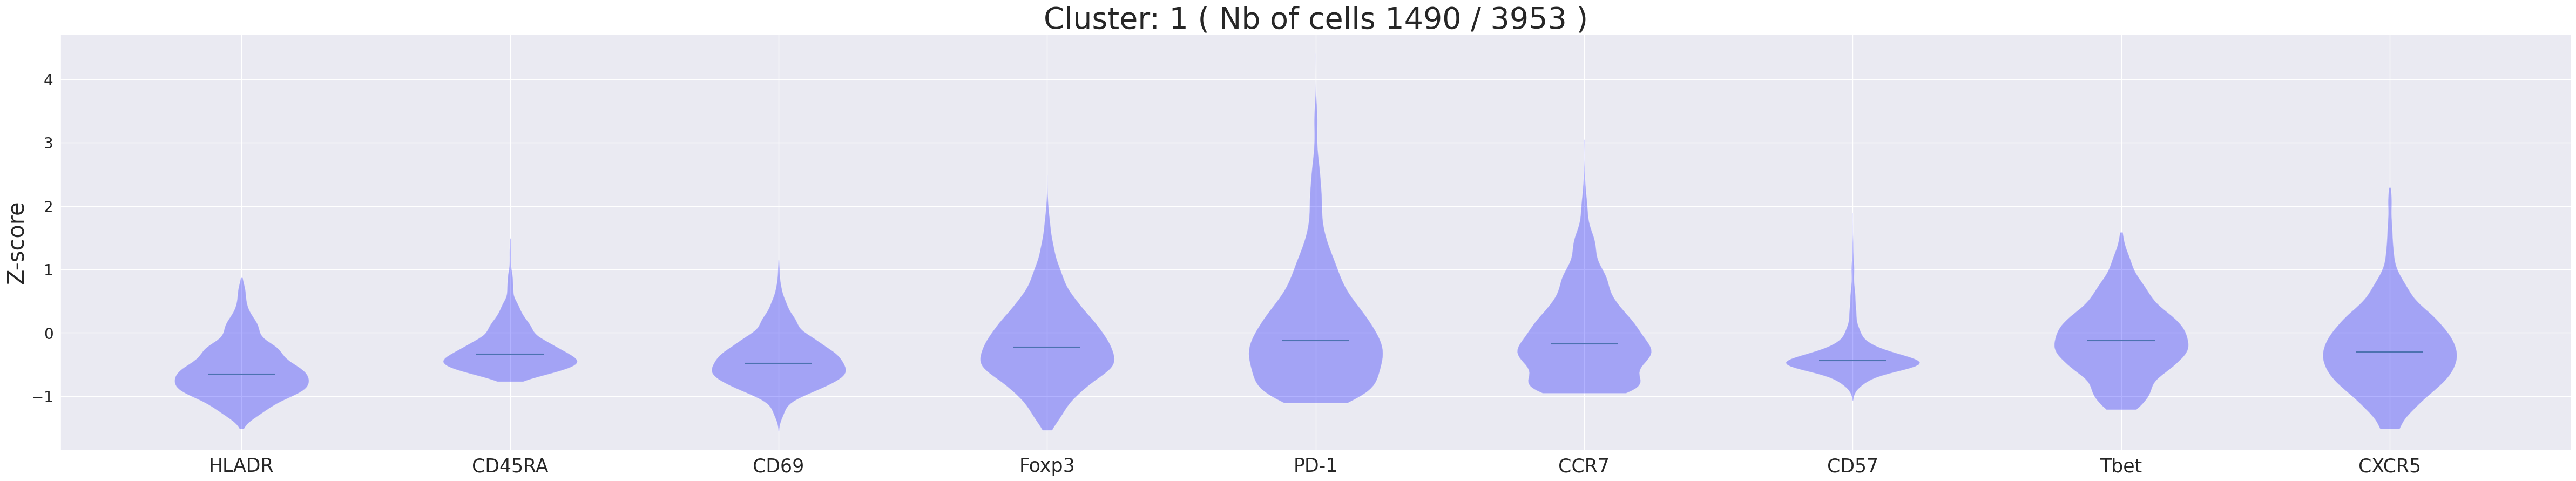

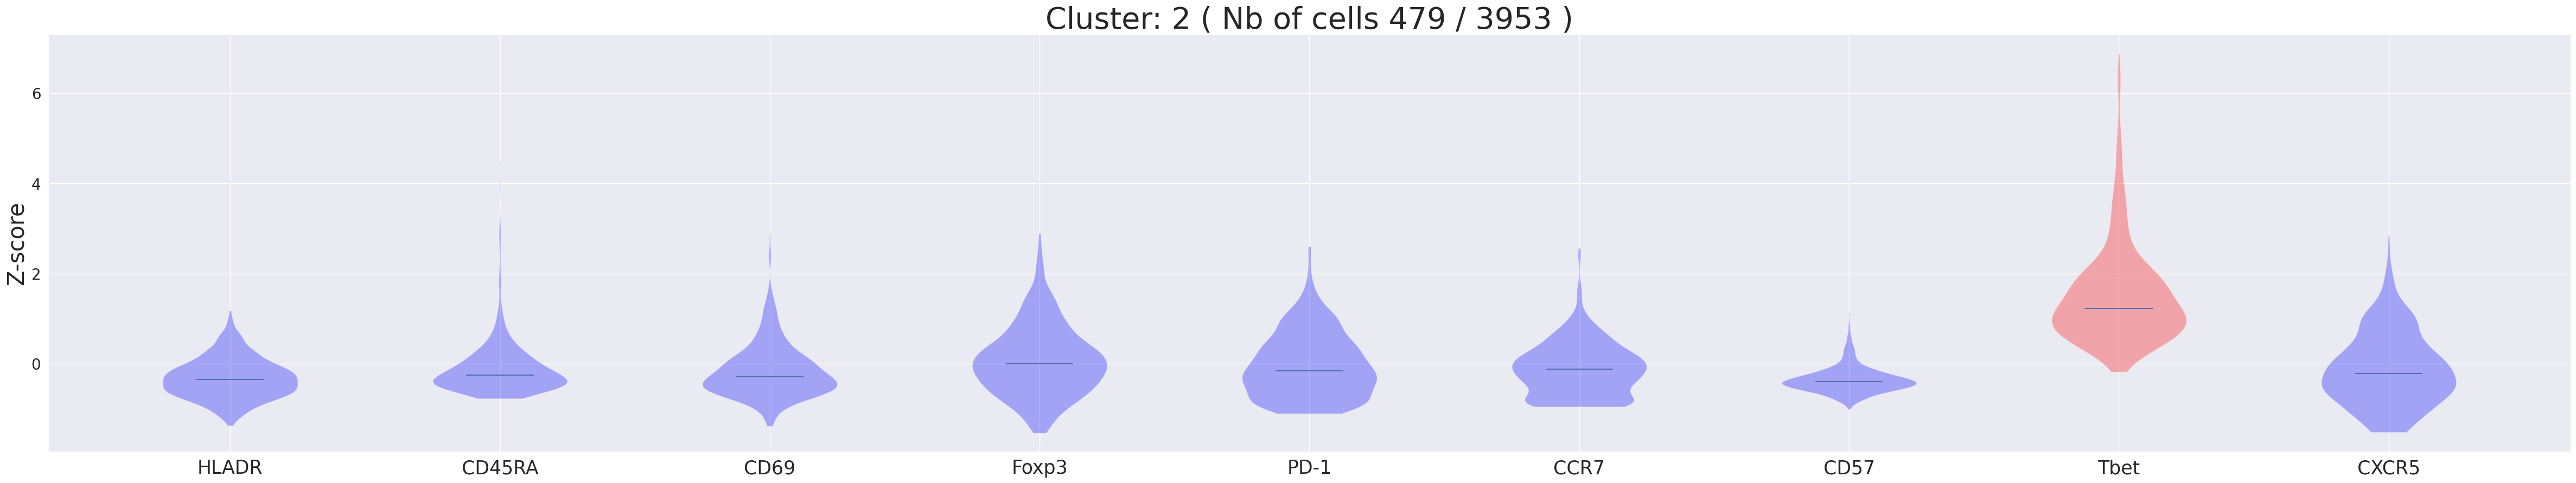

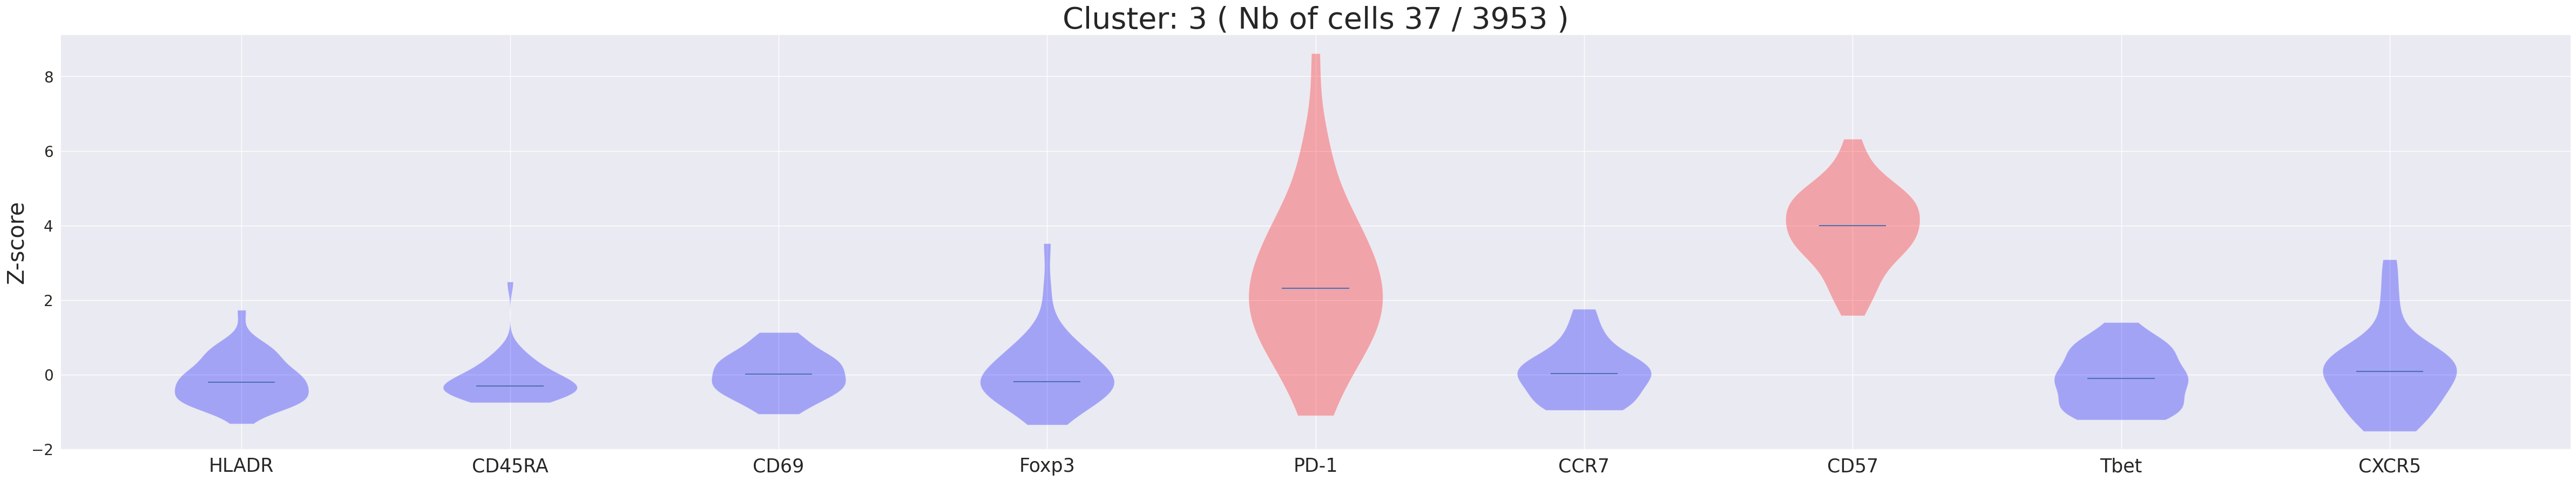

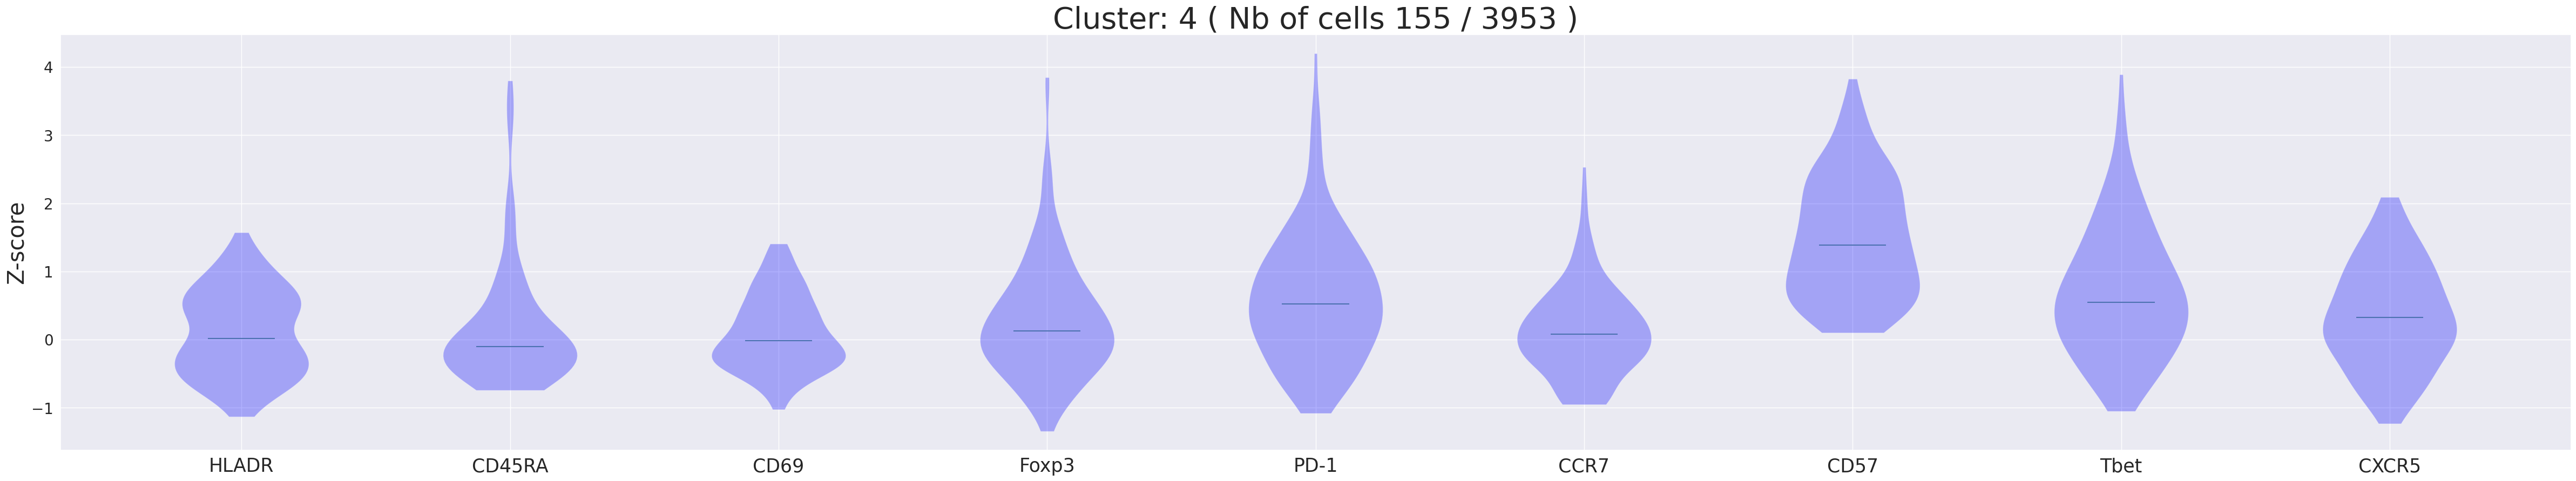

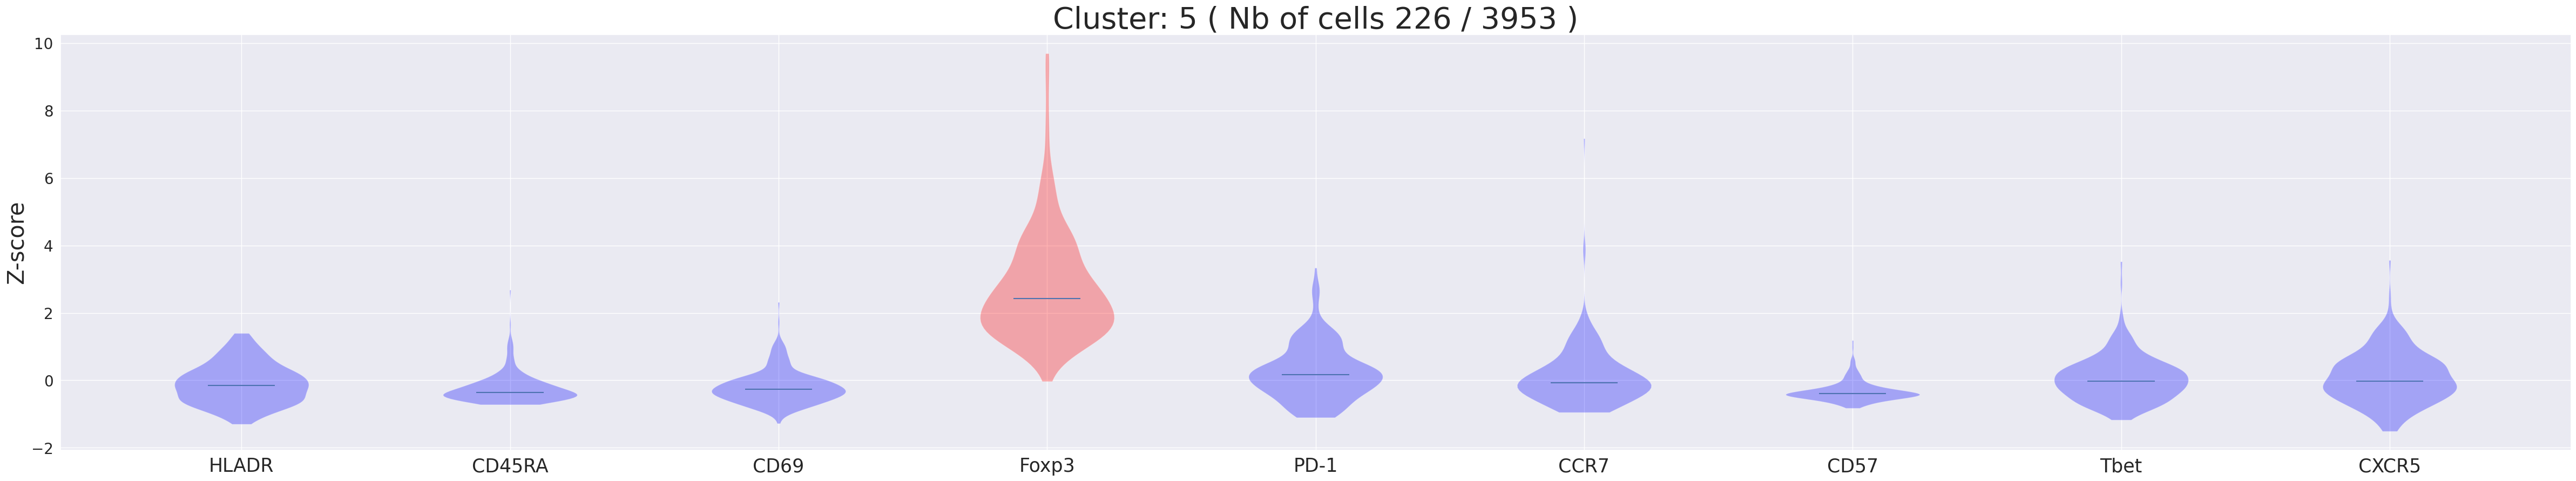

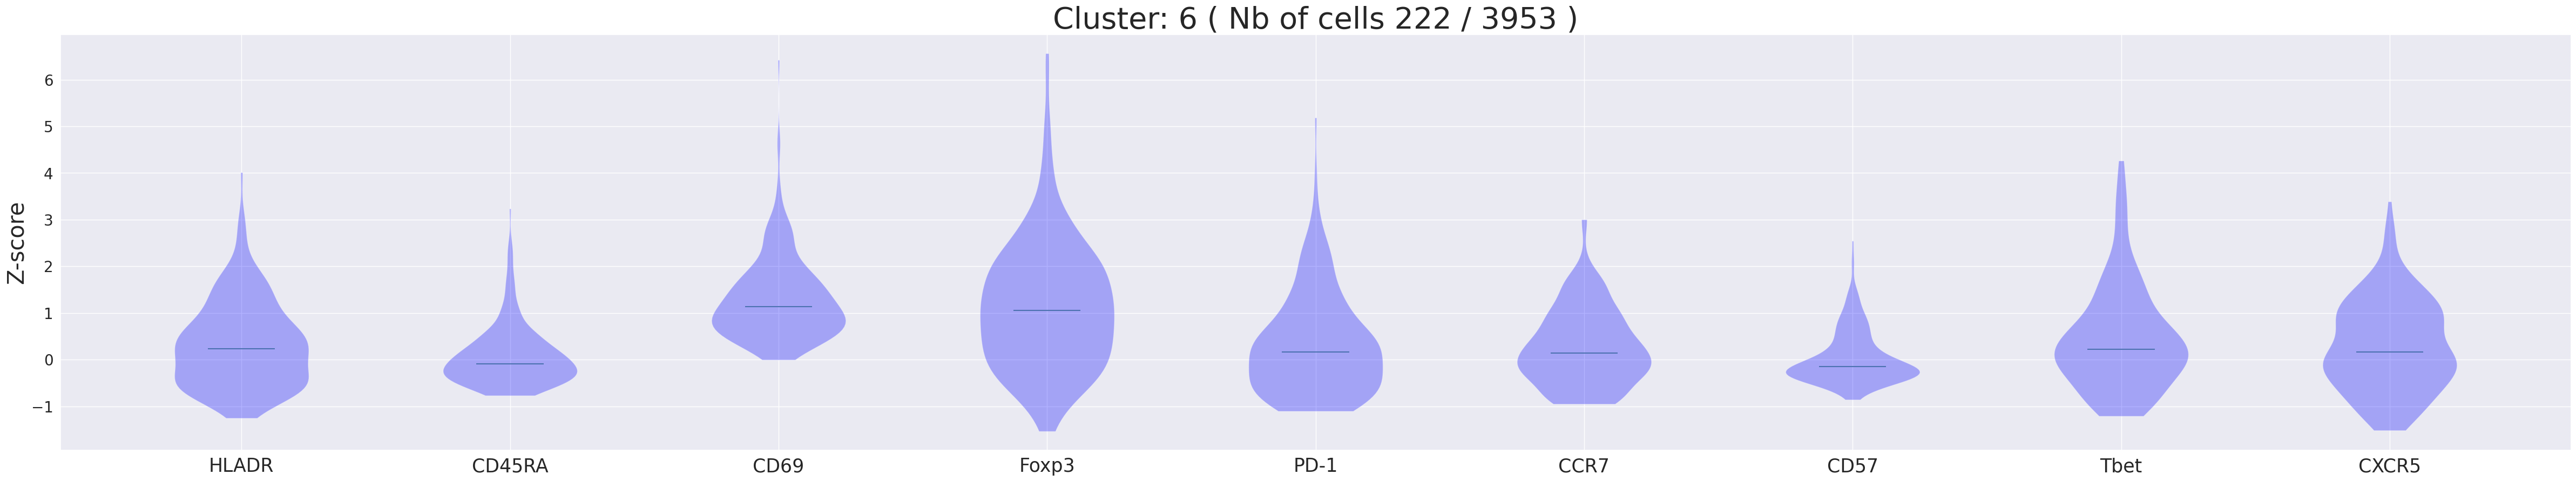

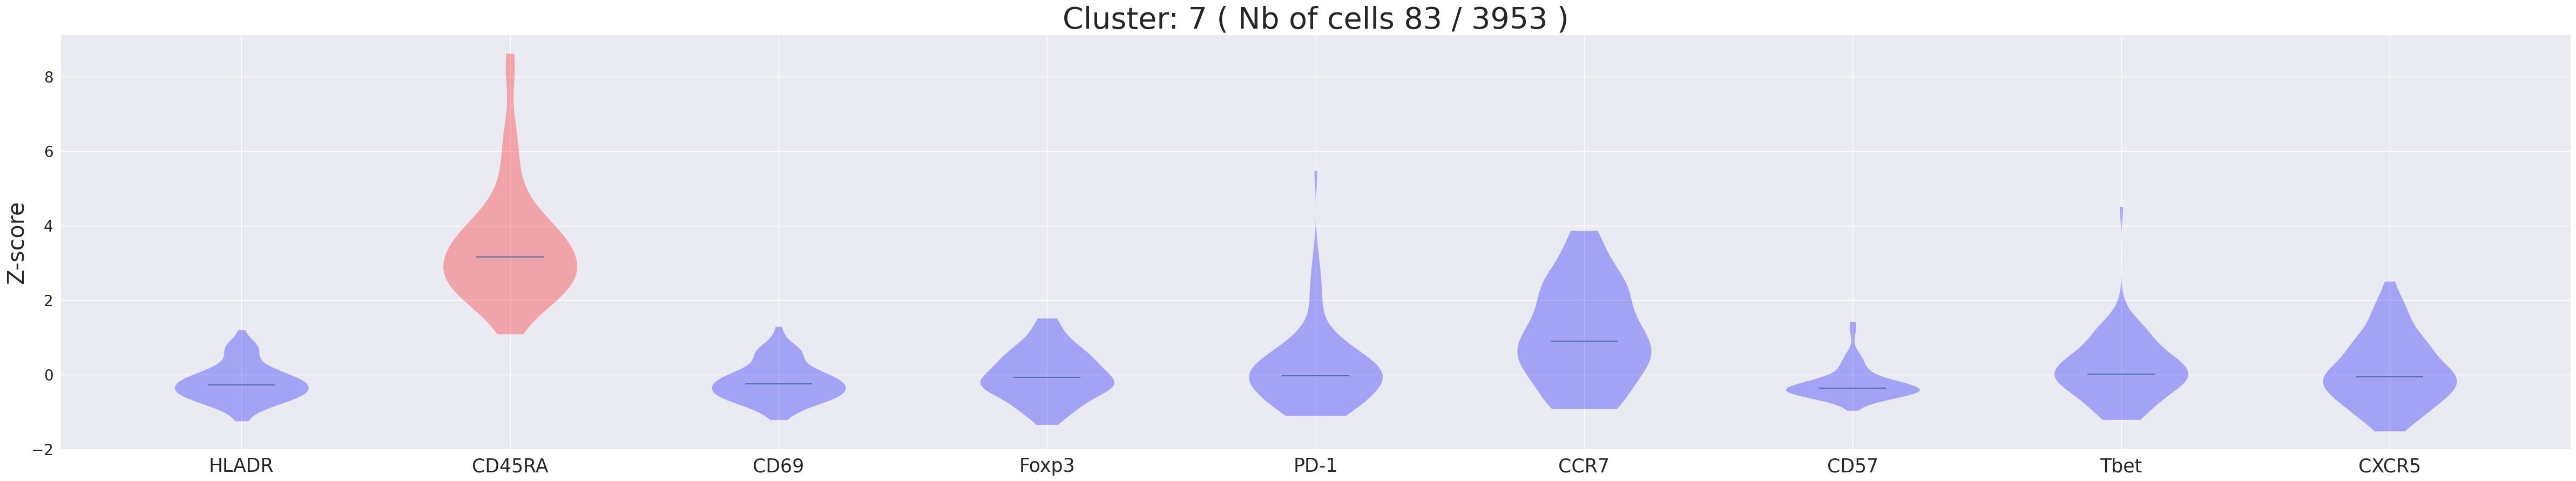

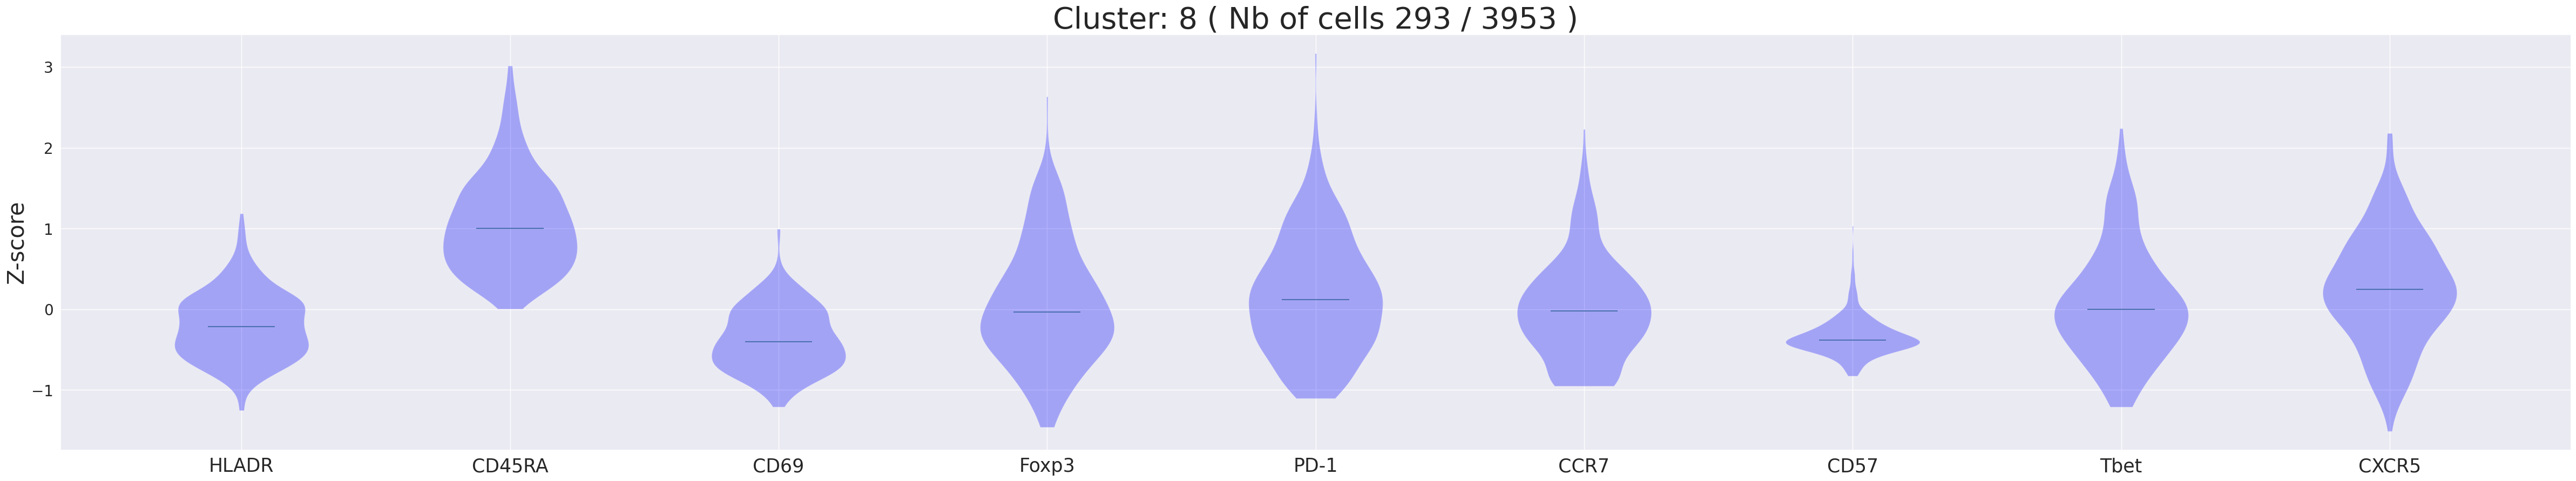

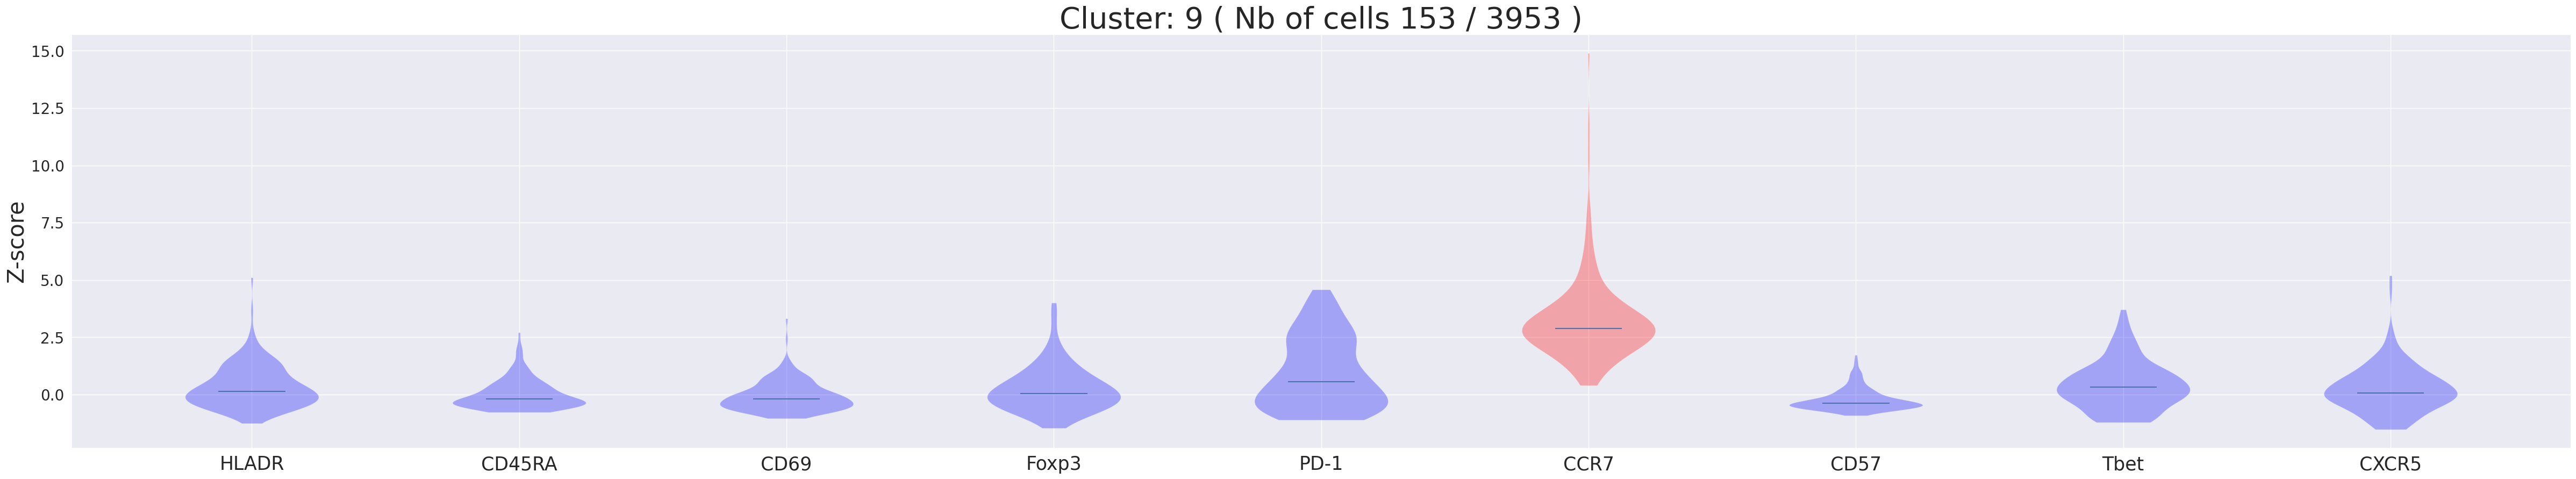

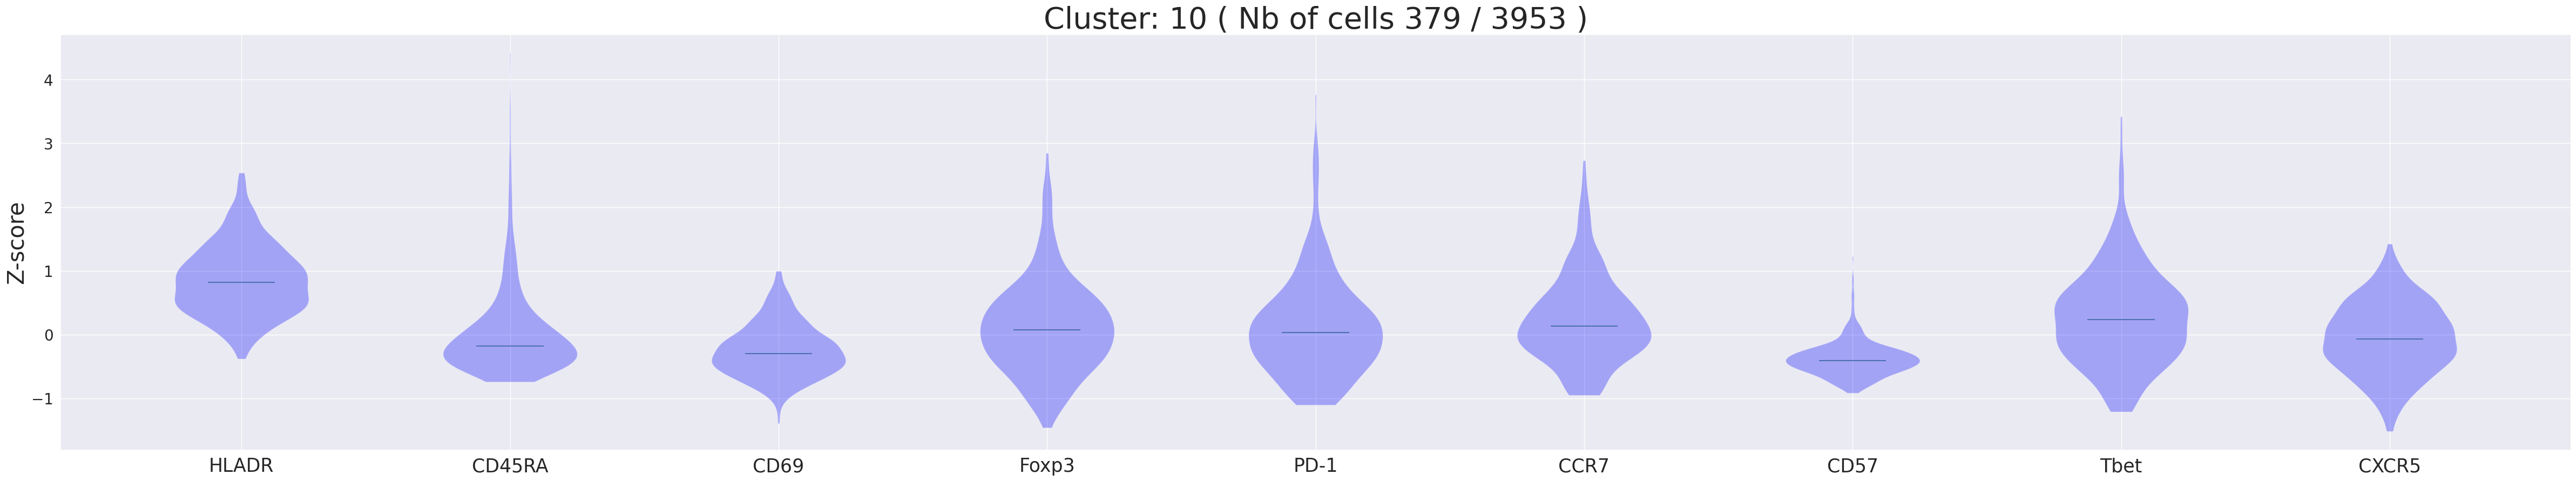

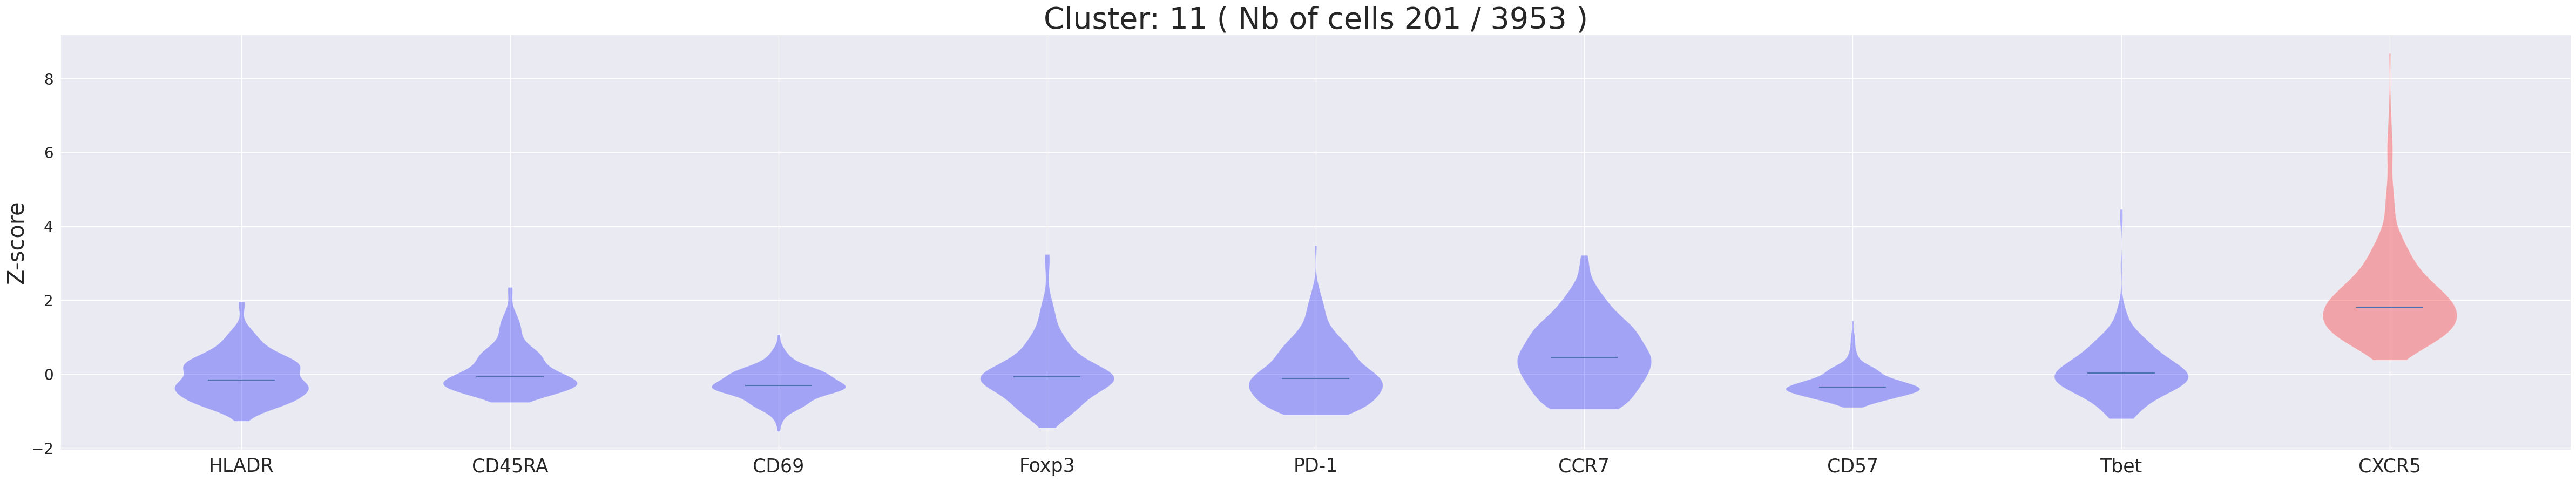

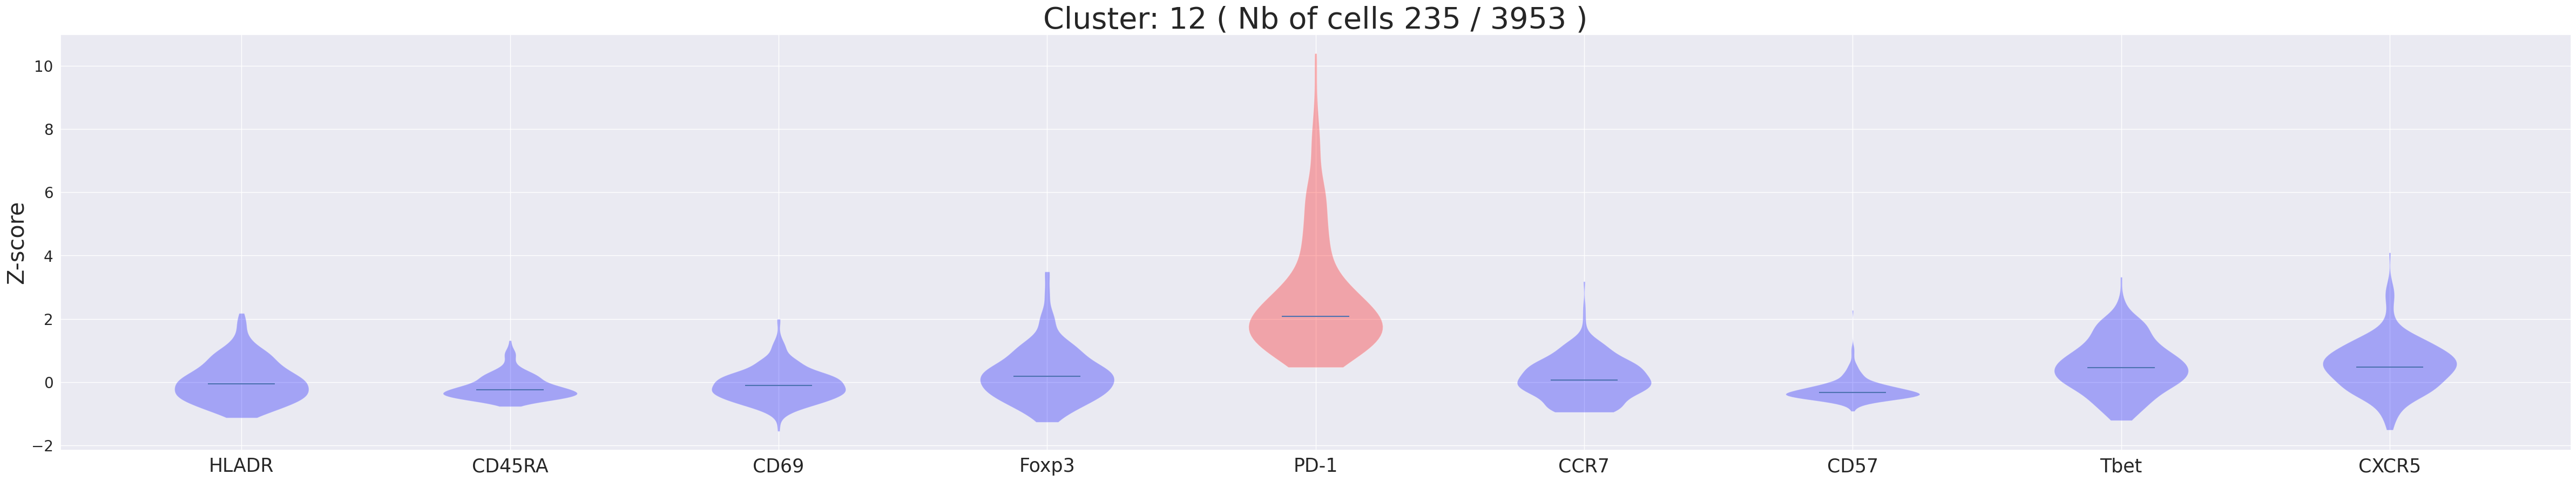

In [ ]:
plot_mfi_cluster(df_subpop_cluster_marker,path_subpop+"plot_mfi_cluster/",thresh=1.5)


### Visualization of clusters on the ROI

#### Function

In [ ]:
def draw_outline(img, list_pixel, color=[255, 0, 0], width=2):
    for pixel in list_pixel:
        x, y = map(int, pixel.split(","))
        for dx in range(-width, width + 1):
            for dy in range(-width, width + 1):
                xi, yi = x + dx, y + dy
                if 0 <= xi < img.shape[0] and 0 <= yi < img.shape[1]:
                    img[xi, yi] = color
    return img


#### Execution

In [ ]:
path_rep=path_subpop+"representation_cluster_roi/"
path_img=path+"images/arcsinh_threshold_marker/"
if os.path.isdir(path_rep)==False:
  os.mkdir(path_rep)

In [ ]:
df_subpop_cluster=pd.read_csv(path_subpop+"mfi_"+pheno+"_subpop_cluster.csv")
df_subpop_cluster.head()

HLADR    CD45RA      CD69     Foxp3      PD-1      CCR7      CD57  \
0  0.379393  0.776029 -0.296844 -0.124624 -0.855866  0.349559 -0.403489   
1 -0.533756 -0.081900 -0.282423  0.131361  0.882198  0.713513 -0.334773   
2 -0.280085 -0.742098 -0.629219 -0.686033 -0.115305 -0.846396  0.918152   
3 -0.217788  0.607424 -0.269207  0.785096 -0.115305  1.146757 -0.415324   
4 -0.503085 -0.081900 -0.770386 -0.692139 -0.855866 -0.846396 -0.788043   

       Tbet     CXCR5         ROI  \
0  0.185720  0.450745  20U03813 a   
1  0.510867  0.572436  20U03813 a   
2  0.185720 -0.015882  20U03813 a   
3  0.007631 -0.482676  20U03813 a   
4  2.597996 -0.036175  20U03813 a   

                                               coord  Cell_ID  cluster  
0  40,449;40,450;40,451;41,448;41,449;41,450;41,4...      119        8  
1  49,0;49,1;49,2;49,3;50,0;50,1;50,2;50,3;50,4;5...      143        1  
2  63,130;63,131;63,132;64,129;64,130;64,131;64,1...      191        1  
3  68,350;68,351;68,352;68,353;69,348;69,349;69,3...      208        1  
4  73,450;73,451;73,452;74,449;74,450;74,451;74,4...      226        2

In [ ]:
df_cluster = df_subpop_cluster_marker.groupby("cluster").mean()
df_max = df_cluster.idxmax(axis=1)
for i in df_max.index:
    df_cluster.loc[i, df_max[i]] = -100
df_max2 = df_cluster.idxmax(axis=1)

list_roi = np.unique(df_subpop["ROI"])

for roi in list_roi:
    for cluster in range(len(df_subpop_cluster["cluster"].unique())):

            marker_max = df_max.iloc[cluster]
            marker_max2 = df_max2.iloc[cluster]

            if not os.path.isdir(path_rep + str(cluster)):
                os.mkdir(path_rep + str(cluster))

            print("Cluster:" + str(cluster))
            print("------ " + roi)
            img_marker = plt.imread(path_img + marker_max + "/" + roi + ".png")
            img_marker2 = plt.imread(path_img + marker_max2 + "/" + roi + ".png")
            img_marker_tot = np.zeros((img_marker.shape[0], img_marker.shape[1], 3))
            img_marker_tot[:, :, 1] = img_marker2
            img_marker_tot[:, :, 0] = img_marker

            img_marker_bin = np.where(img_marker > 0.4, 1, 0)

            img_cluster = np.zeros(img_marker.shape)

            for i in df_subpop_cluster.index:
                if df_subpop_cluster.iloc[i]["cluster"] == cluster and df_subpop_cluster.loc[i, "ROI"] == roi:
                    list_pixel = df_subpop.iloc[i]["coord"].split(";")[:-1]
                    img_marker_tot = outline(img_marker_tot, list_pixel, 2)
                    for pixel in list_pixel:
                        coord = pixel.split(",")
                        img_cluster[int(coord[0]), int(coord[1])] = 255

            plt.figure(figsize=(16, 8))

            plt.subplot(1, 4, 1)
            plt.title(f"Cluster: {cluster}")
            plt.imshow(img_cluster, cmap="gray")
            plt.axis('off')

            plt.subplot(1, 4, 2)
            plt.title(f"Red: {marker_max}, Green: {marker_max2}")
            plt.imshow(img_marker_tot)
            plt.axis('off')

            plt.subplot(1, 4, 3)
            plt.title(marker_max)
            plt.imshow(img_marker, cmap="gray")
            plt.axis('off')

            plt.subplot(1, 4, 4)
            plt.title(marker_max2)
            plt.imshow(img_marker2, cmap="gray")
            plt.axis('off')

            plt.subplots_adjust(wspace=2, hspace=2)
            plt.tight_layout(pad=0)

            plt.savefig(path_rep + str(cluster) + "/" + roi + ".png", bbox_inches='tight', pad_inches=0)
            plt.close()


Cluster:0
------ 20U03813 a
Cluster:1
------ 20U03813 a


Cluster:2
------ 20U03813 a


Cluster:3
------ 20U03813 a
Cluster:4
------ 20U03813 a


Cluster:5
------ 20U03813 a


Cluster:6
------ 20U03813 a


Cluster:7
------ 20U03813 a
Cluster:8
------ 20U03813 a


Cluster:9
------ 20U03813 a


Cluster:10
------ 20U03813 a


Cluster:11
------ 20U03813 a


Cluster:0
------ 20U03813 b
Cluster:1
------ 20U03813 b


Cluster:2
------ 20U03813 b


Cluster:3
------ 20U03813 b
Cluster:4
------ 20U03813 b


KeyboardInterrupt: 

### Display clusters on the dimensionality reduction

#### Functions

In [ ]:

def plot_pacmap(df_pacmap,feature, figsize=(8, 6), savepath=None,title=""):
    # Order phenotypes by frequency (optional but nice for legend)
    pheno_counts = df_pacmap[feature].value_counts()
    phenotypes = pheno_counts.index.tolist()

    # Palette with as many distinct colors as phenotypes
    palette = sns.color_palette("tab20", n_colors=len(phenotypes))
    pheno_to_color = {ph: palette[i] for i, ph in enumerate(phenotypes)}

    plt.figure(figsize=figsize)
    ax = plt.gca()

    # Plot phenotype by phenotype (gives more control than seaborn.scatterplot)
    for ph in phenotypes:
        sub = df_pacmap[df_pacmap[feature] == ph]
        ax.scatter(
            sub['0'],
            sub['1'],
            s=8,
            color=pheno_to_color[ph],
            alpha=0.7,
            edgecolor="none",
            label=f"{ph} (n={len(sub)})"
        )

    ax.set_xlabel("PaCMAP 1", fontsize=11)
    ax.set_ylabel("PaCMAP 2", fontsize=11)
    ax.set_title(title, fontsize=13, pad=10)

    # Legend outside the plot
    ax.legend(
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        borderaxespad=0.0,
        fontsize=9,
        markerscale=4.0,
        title=feature
    )

    # Remove top/right spines for a cleaner look
    sns.despine(ax=ax)

    plt.tight_layout()

    if savepath is not None:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")
        print(f"✅ The graph can be found there:  {savepath}")

    plt.show()




#### Execution

In [ ]:
path_reduc=path_subpop+"reduction_dimension/"
if os.path.isdir(path_reduc)==False:
  os.mkdir(path_reduc)

In [ ]:
df_subpop_cluster=pd.read_csv(path_subpop+"mfi_"+pheno+"_subpop_cluster.csv")
df_subpop_cluster_marker=df_subpop_cluster.drop(["Cell_ID","ROI","coord"],axis=1)

In [ ]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_subpop_cluster_marker)

pacmap = PaCMAP(n_components=2, random_state=0)
X_2d = pacmap.fit_transform(X_scaled, init="pca")
df_pacmap=pd.DataFrame(X_2d,columns=["0","1"])
df_pacmap.to_csv(path_subpop+"pacmap_reduction_pheno_"+pheno+".csv")
df_pacmap["cluster"]=list(df_subpop_cluster["cluster"])

✅ The graph can be found there:  /content/gdrive/MyDrive/these/pipeline/rejection/clustering/LT4/reduction_dimension/Pacmap_clusters


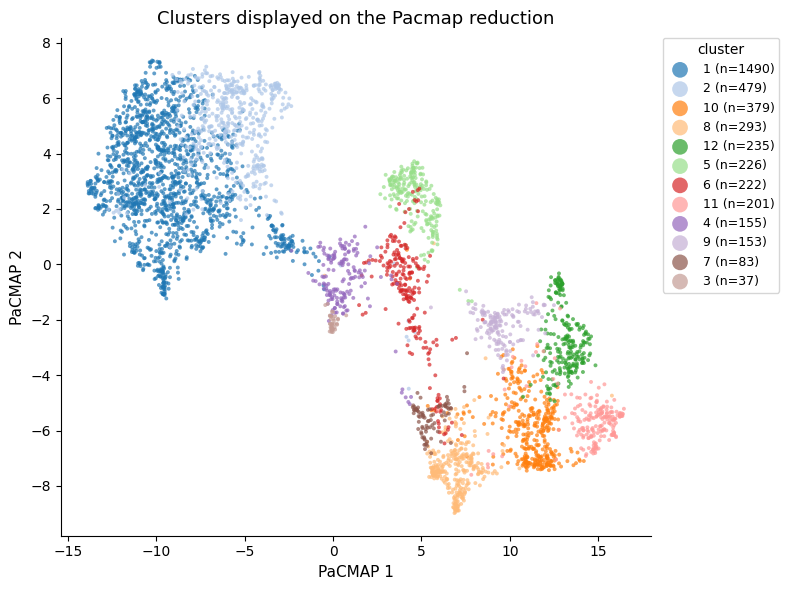

In [ ]:
plot_pacmap(df_pacmap,"cluster", savepath=path_reduc+"Pacmap_clusters",title="Clusters displayed on the Pacmap reduction")


In [ ]:
path_reduc_cluster=path_reduc+"clusters/"
if os.path.isdir(path_reduc_cluster)==False:
  os.mkdir(path_reduc_cluster)

In [ ]:

labels_km = list(df_pacmap["cluster"])

for cluster in df_pacmap["cluster"].unique():
    # Work on a copy
    df = df_pacmap.copy()

    # Create a new column used for coloring:
    # current cluster = its ID, others = "other"
    df["cluster_display"] = np.where(
        df["cluster"] == cluster,
        str(cluster),
        "other"
    )

    savepath = os.path.join(
        path_reduc_cluster,
        f"cluster_{cluster}.png"
    )

    plot_pacmap(
        df,
        "cluster_display",
        savepath=savepath,
        title=f"Cluster {cluster} displayed on the PaCMAP reduction"
    )



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df

0         1
0      8.251558 -7.499446
1     -7.582721  2.879515
2     -2.059467  0.439894
3     -7.099947  2.221134
4     -5.176541  6.743596
...         ...       ...
3948 -11.189503  2.191263
3949  -5.235439  2.845225
3950  12.657212 -3.939038
3951  11.876387 -5.769487
3952  -2.341065  0.852476

[3953 rows x 2 columns]

### Phenotype annotations

In [ ]:

dict_pheno_cluster={}
for cluster in df_subpop_cluster["cluster"].unique():
  pheno=input("Enter the phenotype corresponding to the cluster "+str(cluster)+" :")
  if pheno not in dict_pheno_cluster.keys():
    dict_pheno_cluster[pheno]=[]
  dict_pheno_cluster[pheno].append(cluster)
print(dict_pheno_cluster)

Enter the phenotype corresponding to the cluster 8 :LT4_CD45RA
Enter the phenotype corresponding to the cluster 1 :LT4
Enter the phenotype corresponding to the cluster 2 :LT4_TBET
Enter the phenotype corresponding to the cluster 6 :LT4
Enter the phenotype corresponding to the cluster 9 :LT4_CCR7
Enter the phenotype corresponding to the cluster 11 :LT4_CXCR5
Enter the phenotype corresponding to the cluster 10 :LT4
Enter the phenotype corresponding to the cluster 4 :LT4
Enter the phenotype corresponding to the cluster 5 :LT4_FOXP3
Enter the phenotype corresponding to the cluster 12 :LT4_PD1
Enter the phenotype corresponding to the cluster 7 :LT4_CD45RA
Enter the phenotype corresponding to the cluster 3 :LT4_CD57_PD1
{'LT4_CD45RA': [np.int64(8), np.int64(7)], 'LT4': [np.int64(1), np.int64(6), np.int64(10), np.int64(4)], 'LT4_TBET': [np.int64(2)], 'LT4_CCR7': [np.int64(9)], 'LT4_CXCR5': [np.int64(11)], 'LT4_FOXP3': [np.int64(5)], 'LT4_PD1': [np.int64(12)], 'LT4_CD57_PD1': [np.int64(3)]}


In [ ]:
dict_cluster_pheno={}
for k in dict_pheno_cluster.keys():
  for v in dict_pheno_cluster[k]:
    if v not in dict_cluster_pheno.keys():
     dict_cluster_pheno[v]=k

In [ ]:
df_subpop_cluster["phenotype"]=[dict_cluster_pheno[cluster] for cluster in df_subpop_cluster["cluster"]]
df_subpop_cluster.to_csv(path_subpop+"df_"+pheno+"_subpopulations.csv")
print(df_subpop_cluster.shape)
df_subpop_cluster.head()

(3953, 14)


HLADR    CD45RA      CD69     Foxp3      PD-1      CCR7      CD57  \
0  0.379393  0.776029 -0.296844 -0.124624 -0.855866  0.349559 -0.403489   
1 -0.533756 -0.081900 -0.282423  0.131361  0.882198  0.713513 -0.334773   
2 -0.280085 -0.742098 -0.629219 -0.686033 -0.115305 -0.846396  0.918152   
3 -0.217788  0.607424 -0.269207  0.785096 -0.115305  1.146757 -0.415324   
4 -0.503085 -0.081900 -0.770386 -0.692139 -0.855866 -0.846396 -0.788043   

       Tbet     CXCR5         ROI  \
0  0.185720  0.450745  20U03813 a   
1  0.510867  0.572436  20U03813 a   
2  0.185720 -0.015882  20U03813 a   
3  0.007631 -0.482676  20U03813 a   
4  2.597996 -0.036175  20U03813 a   

                                               coord  Cell_ID  cluster  \
0  40,449;40,450;40,451;41,448;41,449;41,450;41,4...      119        8   
1  49,0;49,1;49,2;49,3;50,0;50,1;50,2;50,3;50,4;5...      143        1   
2  63,130;63,131;63,132;64,129;64,130;64,131;64,1...      191        1   
3  68,350;68,351;68,352;68,353;69,348;69,349;69,3...      208        1   
4  73,450;73,451;73,452;74,449;74,450;74,451;74,4...      226        2   

    phenotype  
0  LT4_CD45RA  
1         LT4  
2         LT4  
3         LT4  
4    LT4_TBET

### Display the phenotypes on the reduction of dimension

#### Functions

In [ ]:

def plot_pacmap(df_pacmap,feature, figsize=(8, 6), savepath=None,title=""):
    # Order phenotypes by frequency (optional but nice for legend)
    pheno_counts = df_pacmap[feature].value_counts()
    phenotypes = pheno_counts.index.tolist()

    # Palette with as many distinct colors as phenotypes
    palette = sns.color_palette("tab20", n_colors=len(phenotypes))
    pheno_to_color = {ph: palette[i] for i, ph in enumerate(phenotypes)}

    plt.figure(figsize=figsize)
    ax = plt.gca()

    # Plot phenotype by phenotype (gives more control than seaborn.scatterplot)
    for ph in phenotypes:
        sub = df_pacmap[df_pacmap[feature] == ph]
        ax.scatter(
            sub['0'],
            sub['1'],
            s=8,
            color=pheno_to_color[ph],
            alpha=0.7,
            edgecolor="none",
            label=f"{ph} (n={len(sub)})"
        )

    ax.set_xlabel("PaCMAP 1", fontsize=11)
    ax.set_ylabel("PaCMAP 2", fontsize=11)
    ax.set_title(title, fontsize=13, pad=10)

    # Legend outside the plot
    ax.legend(
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        borderaxespad=0.0,
        fontsize=9,
        markerscale=4.0,
        title=feature
    )

    # Remove top/right spines for a cleaner look
    sns.despine(ax=ax)

    plt.tight_layout()

    if savepath is not None:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")
        print(f"✅ The graph can be found there:  {savepath}")

    plt.show()




#### Execution

In [ ]:
path_reduc=path_subpop+"reduction_dimension/"
if os.path.isdir(path_reduc)==False:
  os.mkdir(path_reduc)

In [ ]:
df_subpop_pheno=pd.read_csv(path_subpop+"df_"+pheno+"_subpopulations.csv")
df_subpop_pheno.head()

Unnamed: 0     HLADR    CD45RA      CD69     Foxp3      PD-1      CCR7  \
0           0  0.379393  0.776029 -0.296844 -0.124624 -0.855866  0.349559   
1           1 -0.533756 -0.081900 -0.282423  0.131361  0.882198  0.713513   
2           2 -0.280085 -0.742098 -0.629219 -0.686033 -0.115305 -0.846396   
3           3 -0.217788  0.607424 -0.269207  0.785096 -0.115305  1.146757   
4           4 -0.503085 -0.081900 -0.770386 -0.692139 -0.855866 -0.846396   

       CD57      Tbet     CXCR5         ROI  \
0 -0.403489  0.185720  0.450745  20U03813 a   
1 -0.334773  0.510867  0.572436  20U03813 a   
2  0.918152  0.185720 -0.015882  20U03813 a   
3 -0.415324  0.007631 -0.482676  20U03813 a   
4 -0.788043  2.597996 -0.036175  20U03813 a   

                                               coord  Cell_ID  cluster  \
0  40,449;40,450;40,451;41,448;41,449;41,450;41,4...      119        8   
1  49,0;49,1;49,2;49,3;50,0;50,1;50,2;50,3;50,4;5...      143        1   
2  63,130;63,131;63,132;64,129;64,130;64,131;64,1...      191        1   
3  68,350;68,351;68,352;68,353;69,348;69,349;69,3...      208        1   
4  73,450;73,451;73,452;74,449;74,450;74,451;74,4...      226        2   

    phenotype  
0  LT4_CD45RA  
1         LT4  
2         LT4  
3         LT4  
4    LT4_TBET

In [ ]:
df_pacmap=pd.read_csv(path_subpop+"pacmap_reduction_pheno_"+pheno+".csv")
df_pacmap=df_pacmap.drop(["Unnamed: 0"],axis=1)
df_pacmap["phenotype"]=list(df_subpop_pheno["phenotype"])
pacmap_embeded=np.array(df_pacmap)
print(pacmap_embeded.shape)
df_pacmap.head()

(3953, 3)


0         1   phenotype
0  8.251558 -7.499446  LT4_CD45RA
1 -7.582721  2.879515         LT4
2 -2.059467  0.439894         LT4
3 -7.099947  2.221134         LT4
4 -5.176541  6.743596    LT4_TBET

✅ The graph can be found there:  /content/gdrive/MyDrive/these/pipeline/rejection/clustering/LT4/reduction_dimension/pacmap_phenotype.png


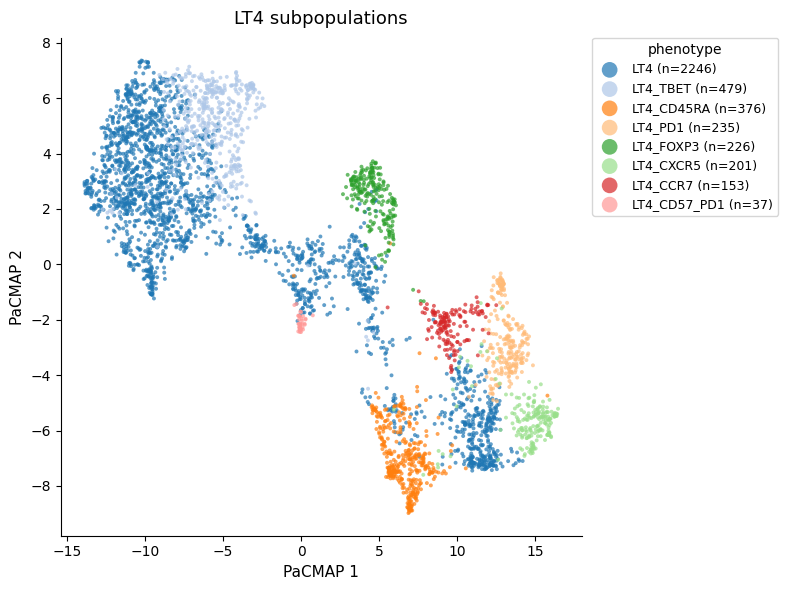

In [ ]:
plot_pacmap(df_pacmap, "phenotype",savepath=path_reduc + "pacmap_phenotype.png",title=pheno+" subpopulations")

### Cells Mask colored according to the phenotype

#### Functions

In [ ]:
def parse_coord_string(coord_str):
    if pd.isna(coord_str):
        return []

    points = []
    for pair in str(coord_str).split(";"):
        pair = pair.strip()
        if not pair:
            continue
        try:
            x_str, y_str = pair.split(",")
            y= int(float(x_str.replace(",", ".").replace(" ", "")))
            x = int(float(y_str.replace(",", ".").replace(" ", "")))
            points.append((x, y))
        except ValueError:
            continue

    return points
# ======================================================================
# Default color mapping if user does NOT provide a color dictionary
# ======================================================================
def build_color_mapping(df, custom_colors=None, alpha=160):
    """
    Returns a phenotype -> RGBA color mapping.

    If custom_colors is None:
        Use a default colormap (tab20) to assign a unique color to each phenotype.

    If custom_colors is provided:
        Only override colors for phenotypes present in the dictionary.
        The remaining phenotypes receive automatic colors.
    """
    phenotypes = df["phenotype"].unique()
    pheno_to_color = {}

    # -- Default colors (matplotlib tab20) --
    default_cmap = plt.get_cmap("tab20", len(phenotypes))

    # Assign default colors first
    for i, ph in enumerate(phenotypes):
        r, g, b, _ = default_cmap(i)
        pheno_to_color[ph] = (int(r * 255), int(g * 255), int(b * 255), alpha)

    # Override with user-defined colors if provided
    if custom_colors is not None:
        from matplotlib.colors import to_rgba

        for ph, col in custom_colors.items():
            if ph in pheno_to_color:
                r, g, b, a = to_rgba(col)
                pheno_to_color[ph] = (int(r * 255), int(g * 255), int(b * 255), alpha)

    return pheno_to_color


# ======================================================================
# Create legend as a PIL image
# ======================================================================
def create_legend_image(pheno_to_color, fontsize=10):
    """
    Build a legend (patch + label) as a PIL image.
    """
    patches = [
        mpatches.Patch(color=np.array(c[:3]) / 255.0, label=str(ph))
        for ph, c in pheno_to_color.items()
    ]

    fig, ax = plt.subplots(figsize=(3, len(patches) * 0.5))
    ax.axis("off")

    fig.legend(handles=patches, loc="upper left", fontsize=fontsize, title="Phenotypes")

    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=200, bbox_inches="tight", transparent=True)
    plt.close(fig)

    buf.seek(0)
    legend_img = Image.open(buf).convert("RGBA")
    return legend_img


# ======================================================================
# Attach legend image to the base image
# ======================================================================
def attach_legend_to_image(base_image, legend_image, position="right", padding=20):
    """
    Merge base_image and legend_image into one final image.
    position = "right" or "bottom"
    """
    bw, bh = base_image.size
    lw, lh = legend_image.size

    if position == "right":
        new_img = Image.new("RGBA", (bw + lw + padding, max(bh, lh)), (255, 255, 255, 255))
        new_img.paste(base_image, (0, 0))
        new_img.paste(legend_image, (bw + padding, 0), legend_image)

    elif position == "bottom":
        new_img = Image.new("RGBA", (max(bw, lw), bh + lh + padding), (255, 255, 255, 255))
        new_img.paste(base_image, (0, 0))
        new_img.paste(legend_image, (0, bh + padding), legend_image)

    return new_img


# ======================================================================
# Main function
# ======================================================================
def draw_cells_for_roi(df_roi,
                       roi,
                       path_img,
                       image_ext=".png",
                       custom_colors=None,
                       path_img_pheno=None,
                       save=True,
                       show=True,
                       alpha=160):

    """
    Draw cell polygons colored by phenotype, overlay them on the ROI image,
    and attach a legend on the right.

    If custom_colors is None:
        Automatically generate distinct default colors.
    """

    # Build color mapping (default or user-defined)
    pheno_to_color = build_color_mapping(df_roi, custom_colors, alpha)

    # Load base image
    img_name = f"{roi}/CD4{image_ext}"
    img_path = os.path.join(path_img, img_name)
    base_img = Image.open(img_path).convert("RGBA")

    # Create overlay for polygons
    overlay = Image.new("RGBA", base_img.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(overlay, "RGBA")

    for _, row in df_roi.iterrows():
        coords = parse_coord_string(row["coord"])
        if len(coords) >= 3:
            color = pheno_to_color[row["phenotype"]]
            draw.polygon(coords, fill=color, outline=color)

    # Merge base + overlay
    masked_img = Image.alpha_composite(base_img, overlay)

    # Build legend
    legend_img = create_legend_image(pheno_to_color)

    # Attach legend to the right
    final_img = attach_legend_to_image(masked_img, legend_img, position="right")

    # Save
    if save and path_img_pheno is not None:
        os.makedirs(path_img_pheno, exist_ok=True)
        save_path = os.path.join(path_img_pheno, f"{roi}{image_ext}")
        final_img.save(save_path)

    # Display
    if show:
        plt.figure(figsize=(10, 10))
        plt.imshow(final_img)
        plt.axis("off")
        plt.title(f"ROI : {roi}")
        plt.show()


#### Execution

In [ ]:
path_subpop_pheno=path_subpop+"images_phenotype/"
if os.path.isdir(path_subpop_pheno)==False:
  os.mkdir(path_subpop_pheno)

In [ ]:
df_subpop_pheno=pd.read_csv(path_subpop+"df_"+pheno+"_subpopulations.csv")
df_subpop_pheno.head()

Unnamed: 0     HLADR    CD45RA      CD69     Foxp3      PD-1      CCR7  \
0           0  0.379393  0.776029 -0.296844 -0.124624 -0.855866  0.349559   
1           1 -0.533756 -0.081900 -0.282423  0.131361  0.882198  0.713513   
2           2 -0.280085 -0.742098 -0.629219 -0.686033 -0.115305 -0.846396   
3           3 -0.217788  0.607424 -0.269207  0.785096 -0.115305  1.146757   
4           4 -0.503085 -0.081900 -0.770386 -0.692139 -0.855866 -0.846396   

       CD57      Tbet     CXCR5         ROI  \
0 -0.403489  0.185720  0.450745  20U03813 a   
1 -0.334773  0.510867  0.572436  20U03813 a   
2  0.918152  0.185720 -0.015882  20U03813 a   
3 -0.415324  0.007631 -0.482676  20U03813 a   
4 -0.788043  2.597996 -0.036175  20U03813 a   

                                               coord  Cell_ID  cluster  \
0  40,449;40,450;40,451;41,448;41,449;41,450;41,4...      119        8   
1  49,0;49,1;49,2;49,3;50,0;50,1;50,2;50,3;50,4;5...      143        1   
2  63,130;63,131;63,132;64,129;64,130;64,131;64,1...      191        1   
3  68,350;68,351;68,352;68,353;69,348;69,349;69,3...      208        1   
4  73,450;73,451;73,452;74,449;74,450;74,451;74,4...      226        2   

    phenotype  
0  LT4_CD45RA  
1         LT4  
2         LT4  
3         LT4  
4    LT4_TBET

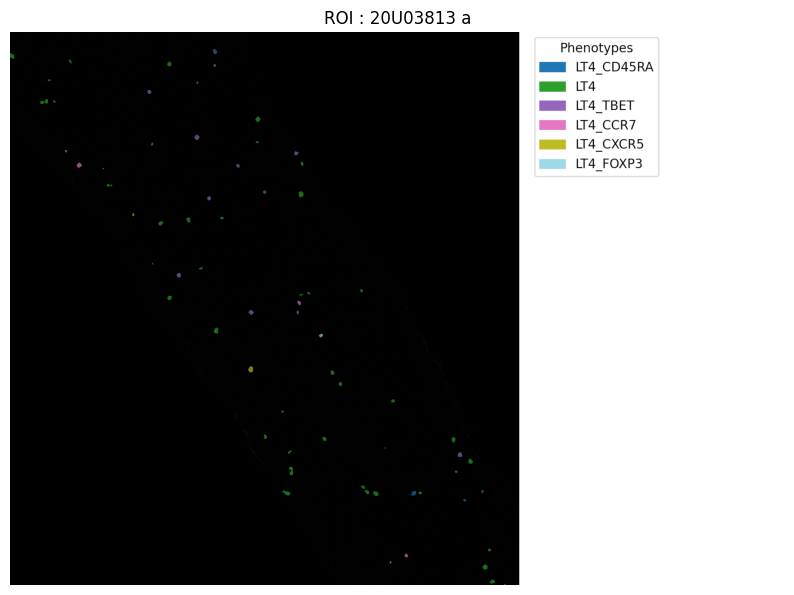

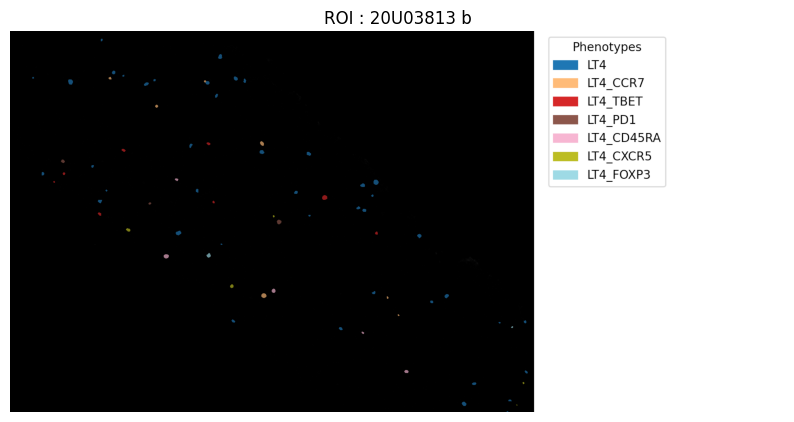

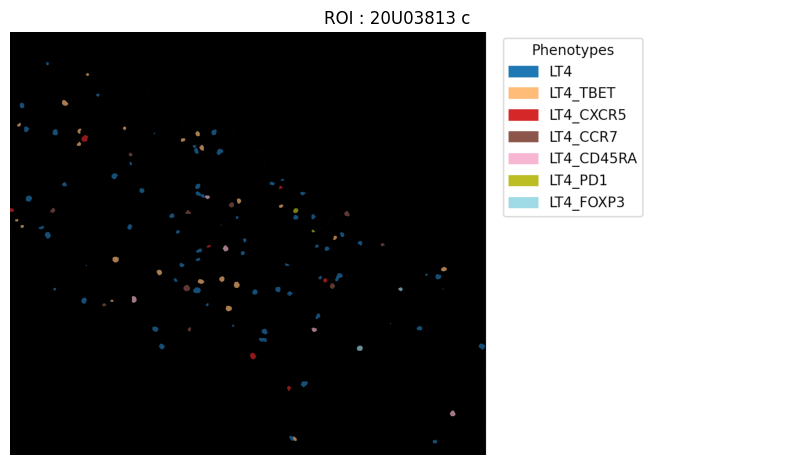

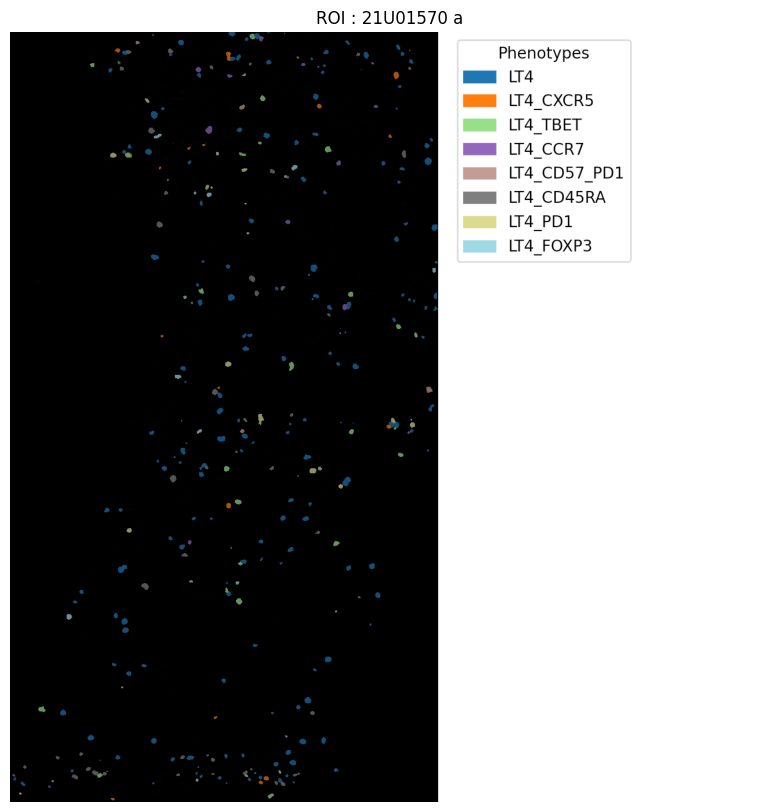

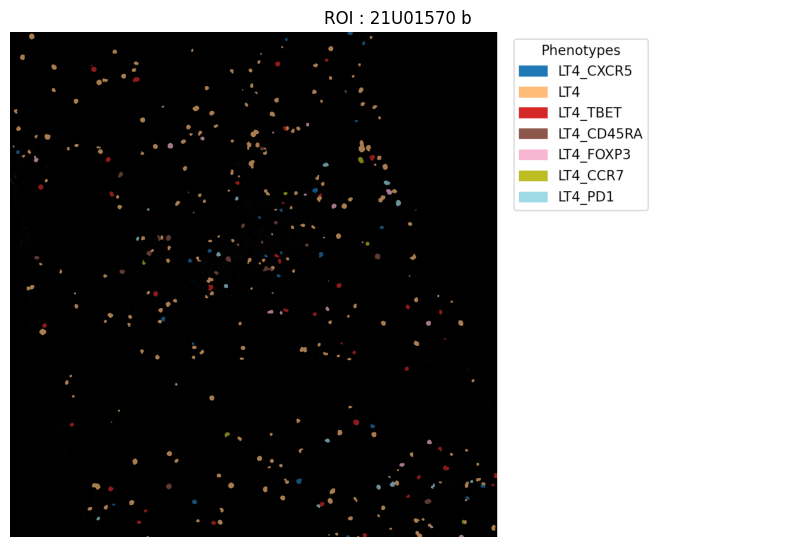

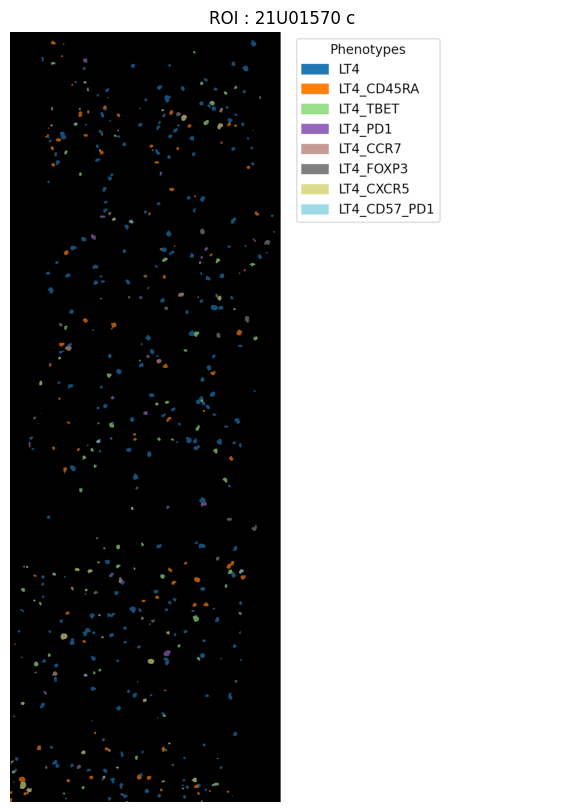

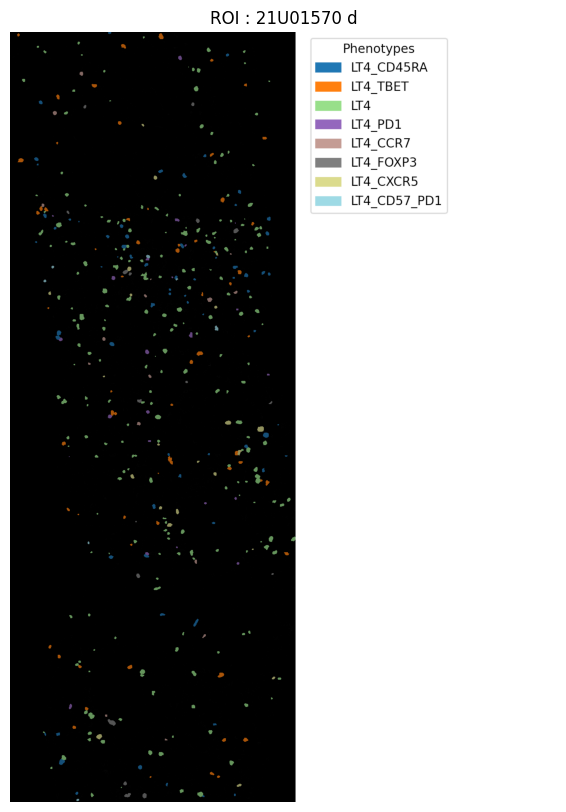

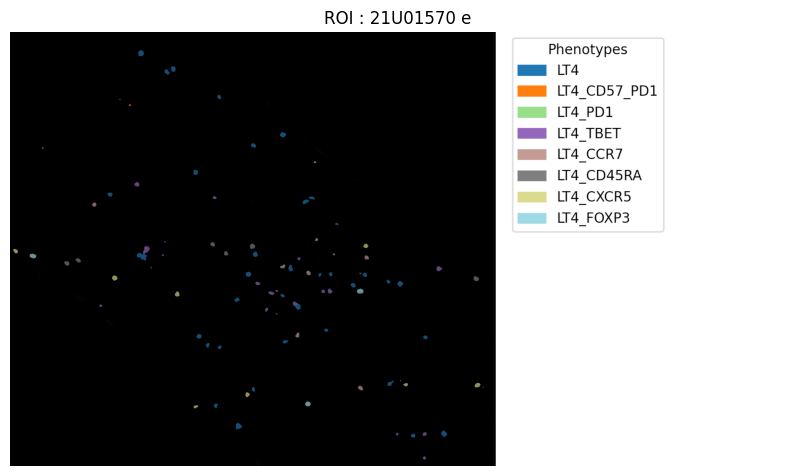

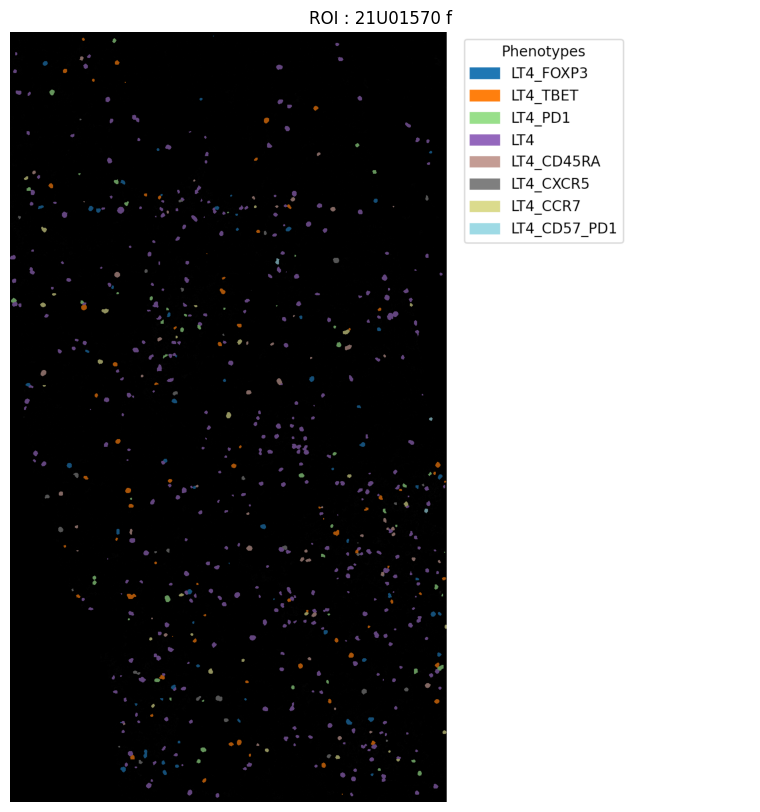

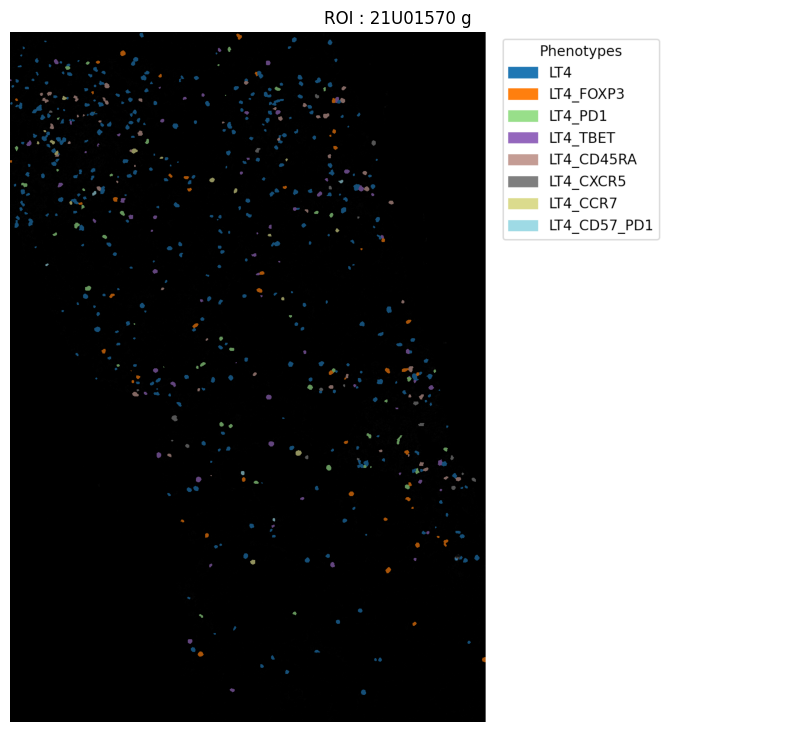

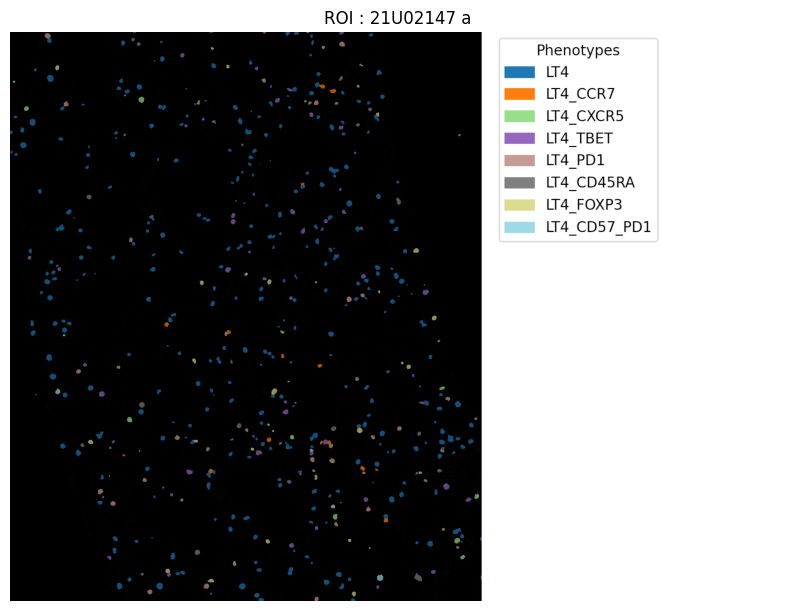

In [ ]:

for roi_exemple in np.unique(df_subpop_pheno["ROI"]):
 df_roi_exemple = df_subpop_pheno[df_subpop_pheno["ROI"] == roi_exemple]

 draw_cells_for_roi(
    df_roi_exemple,
    roi_exemple,
    path_img=path_img_raw,
    image_ext=".png",
    custom_colors=None,
    path_img_pheno=path_subpop_pheno,  # dossier de sortie
    save=True,
    show=True,
    alpha=170   # tu peux jouer sur cette valeur (150–200)
)


### Heatmap of the markers expression according to the phenotype

#### Function

In [ ]:
def heatmap_histo(df, name_value, title, path, threshold, vmin, vmax):

    sns.set(font_scale=1)

    # --- Data ---
    data = df.groupby(name_value).mean()
    counts = df[name_value].value_counts().sort_index()

    linkage_result = linkage(data, method="ward")
    order = leaves_list(linkage_result)
    data = data.iloc[order]
    counts = counts.iloc[order]

    n_clusters = len(data)
    fig = plt.figure(figsize=(10, max(6, n_clusters * 0.4)))
    fig.patch.set_facecolor('white')
    gs = GridSpec(nrows=1, ncols=2, width_ratios=[1.2, 5], wspace=0.02)

    # --- Histogram ---
    ax_bar = fig.add_subplot(gs[0])
    y_positions = [i + 0.5 for i in range(n_clusters)]

    bars = ax_bar.barh(
        y=y_positions,
        width=counts.values,
        height=1,
        color='gray'
    )

    # Add cell counts inside the histogram
    for y, count in zip(y_positions, counts.values):
        ax_bar.text(
            count - 1,
            y,
            str(count),
            va='center',
            ha='right',
            fontsize=8
        )

    ax_bar.set_yticks([])
    ax_bar.invert_xaxis()
    ax_bar.set_xlabel("")
    ax_bar.set_xticks([])
    ax_bar.xaxis.set_label_position('top')
    ax_bar.set_facecolor('none')
    ax_bar.yaxis.set_ticks_position('none')

    for spine in ['top', 'right', 'bottom']:
        ax_bar.spines[spine].set_visible(False)

    # --- NEW: Left-side legend for histogram ---
    ax_bar.set_ylabel("Number of cells", fontsize=11, labelpad=25, rotation=90)
    ax_bar.yaxis.set_label_position("left")

    # --- Heatmap ---
    ax_heatmap = fig.add_subplot(gs[1])
    heatmap = sns.heatmap(
        data,
        ax=ax_heatmap,
        vmin=vmin,
        vmax=vmax,
        cmap="vlag",
        linewidths=0.5,
        linecolor='gray',
        xticklabels=True,
        yticklabels=False,
        cbar=False
    )

    ax_heatmap.set_yticks([i + 0.5 for i in range(n_clusters)])
    ax_heatmap.set_yticklabels(data.index, fontsize=12)
    ax_heatmap.yaxis.tick_right()
    ax_heatmap.yaxis.set_label_position("right")

    # Align histogram with heatmap height
    ax_bar.set_ylim(ax_heatmap.get_ylim())

    # --- Red boxes above threshold ---
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            value = data.iloc[i, j]
            if value > threshold:
                rect = Rectangle((j, i), 1, 1, linewidth=2, edgecolor='red', facecolor='none')
                ax_heatmap.add_patch(rect)

    # --- Main title ---
    fig.suptitle(title, fontsize=16, y=1.05)

    # --- Colorbar above heatmap ---
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.cm as cm

    norm = plt.Normalize(vmin=data.values.min(), vmax=data.values.max())
    sm = plt.cm.ScalarMappable(cmap="vlag", norm=norm)
    sm.set_array([])

    cax = fig.add_axes([0.13, 0.94, 0.3, 0.015])
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=8)

    # --- Save ---
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig(path + f"Heatmap_{name_value}.png", bbox_inches='tight')
    plt.show()


#### Execution

In [ ]:
df_subpop_pheno=pd.read_csv(path_subpop+"df_"+pheno+"_subpopulations.csv")
df_subpop_pheno = df_subpop_pheno.drop(["Cell_ID", "ROI", "coord","Unnamed: 0","cluster"], axis=1)
df_subpop_pheno.head()

HLADR    CD45RA      CD69     Foxp3      PD-1      CCR7      CD57  \
0  0.379393  0.776029 -0.296844 -0.124624 -0.855866  0.349559 -0.403489   
1 -0.533756 -0.081900 -0.282423  0.131361  0.882198  0.713513 -0.334773   
2 -0.280085 -0.742098 -0.629219 -0.686033 -0.115305 -0.846396  0.918152   
3 -0.217788  0.607424 -0.269207  0.785096 -0.115305  1.146757 -0.415324   
4 -0.503085 -0.081900 -0.770386 -0.692139 -0.855866 -0.846396 -0.788043   

       Tbet     CXCR5   phenotype  
0  0.185720  0.450745  LT4_CD45RA  
1  0.510867  0.572436         LT4  
2  0.185720 -0.015882         LT4  
3  0.007631 -0.482676         LT4  
4  2.597996 -0.036175    LT4_TBET

/tmp/ipython-input-259046493.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.93])


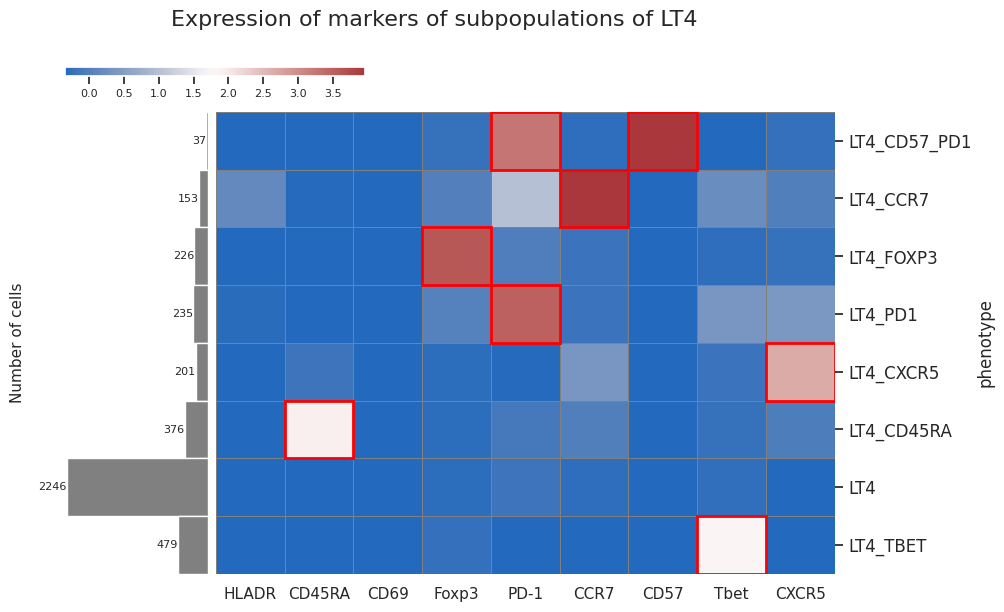

In [ ]:
heatmap_histo(df_subpop_pheno,"phenotype","Expression of markers of subpopulations of "+pheno,path_subpop,threshold=1.5,vmin=0,vmax=3)


### MFI of the markers in the phenotype

#### Functions

In [ ]:
def plot_mfi_pheno(df_mfi,path):

  list_pheno=np.unique(df_mfi["phenotype"])
  for pheno in list_pheno:
     print("pheno: "+str(pheno))
     list_data=[]
     list_marker=sorted(df_mfi.columns[:-1])
     for m in list_marker:
       list_mfi=list(df_mfi.loc[df_mfi.loc[:,"phenotype"]==pheno][m])
       list_data.append(list_mfi)
     list_col=[]
     for i in range(len(list_data)):
        if np.mean(list_data[i])>1.5:
          list_col.append("red")
        else:
          list_col.append("blue")

     pos=[float(p) for p in range(0,len(list_data))]
     fig,ax = plt.subplots(1,1,figsize=(70,10))
     violin=plt.violinplot(list_data,pos,showextrema=False,showmedians=True)
     c=0
     for pc in violin['bodies']:
       pc.set_facecolor(list_col[c])
       c+=1
     ax.set_title("Phenotype: "+pheno+": "+str(df_mfi.loc[df_mfi.loc[:,"phenotype"]==pheno].shape[0]),fontsize=40)
     plt.ylabel("Z-score",size=30)
     ax.set_xticks(np.arange(0,len(list_marker)),list_marker,size=25)
     plt.savefig(path+str(pheno)+".png")


#### Execution

In [ ]:
path_plot_mfi_pheno=path_subpop+"plot_mfi_pheno/"
if os.path.isdir(path_plot_mfi_pheno)==False:
  os.mkdir(path_plot_mfi_pheno)

In [ ]:
df_subpop_pheno=pd.read_csv(path_subpop+"df_"+pheno+"_subpopulations.csv")
df_subpop_pheno = df_subpop_pheno.drop(["Cell_ID", "ROI", "coord","Unnamed: 0","cluster"], axis=1)
df_subpop_pheno.head()

HLADR    CD45RA      CD69     Foxp3      PD-1      CCR7      CD57  \
0  0.379393  0.776029 -0.296844 -0.124624 -0.855866  0.349559 -0.403489   
1 -0.533756 -0.081900 -0.282423  0.131361  0.882198  0.713513 -0.334773   
2 -0.280085 -0.742098 -0.629219 -0.686033 -0.115305 -0.846396  0.918152   
3 -0.217788  0.607424 -0.269207  0.785096 -0.115305  1.146757 -0.415324   
4 -0.503085 -0.081900 -0.770386 -0.692139 -0.855866 -0.846396 -0.788043   

       Tbet     CXCR5   phenotype  
0  0.185720  0.450745  LT4_CD45RA  
1  0.510867  0.572436         LT4  
2  0.185720 -0.015882         LT4  
3  0.007631 -0.482676         LT4  
4  2.597996 -0.036175    LT4_TBET

pheno: LT4
pheno: LT4_CCR7
pheno: LT4_CD45RA
pheno: LT4_CD57_PD1
pheno: LT4_CXCR5
pheno: LT4_FOXP3
pheno: LT4_PD1
pheno: LT4_TBET


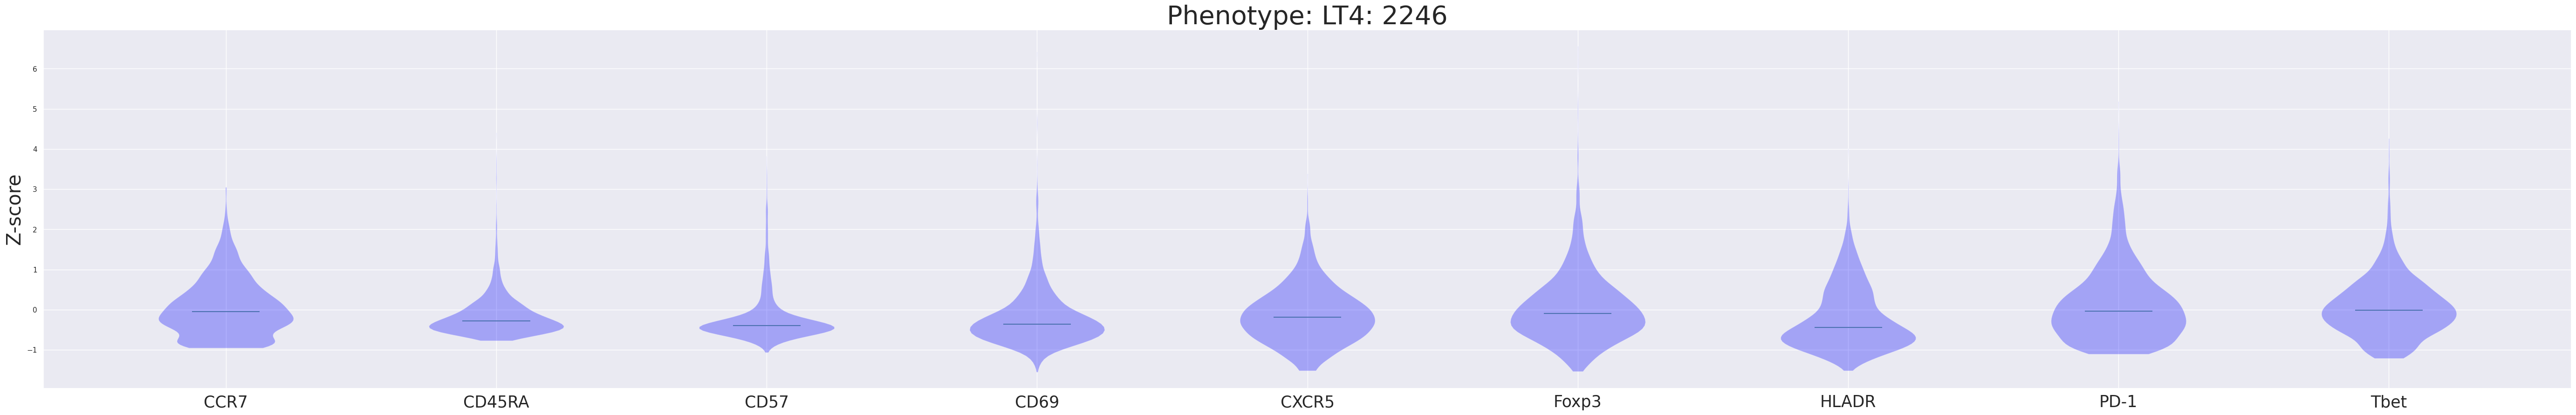

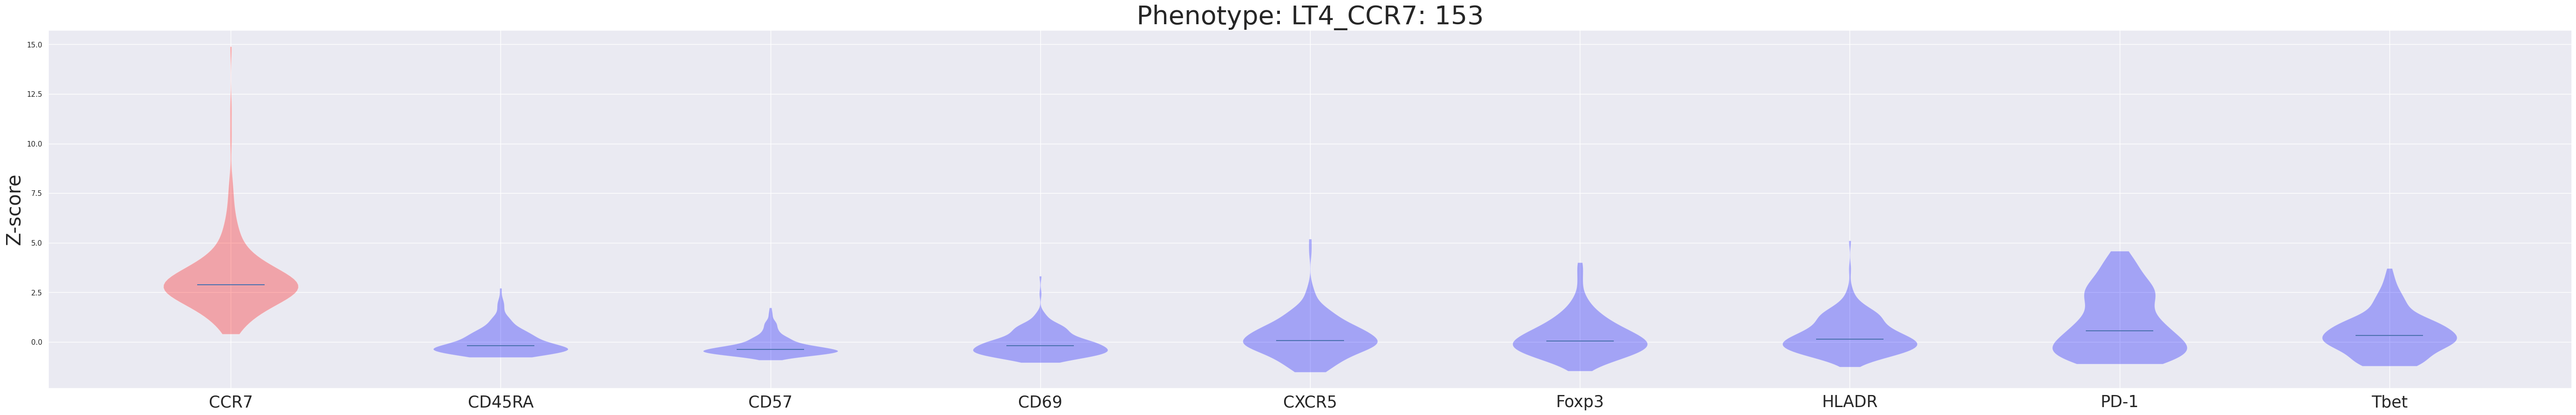

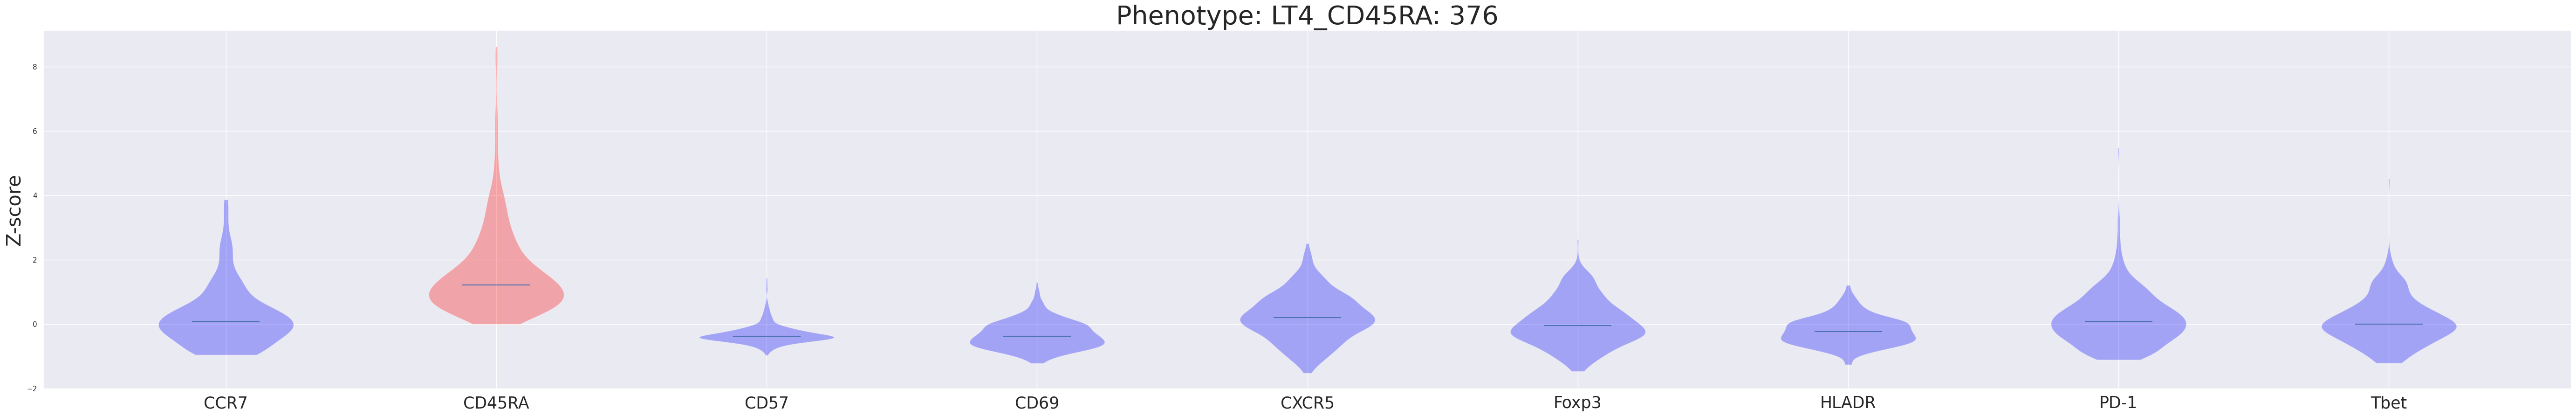

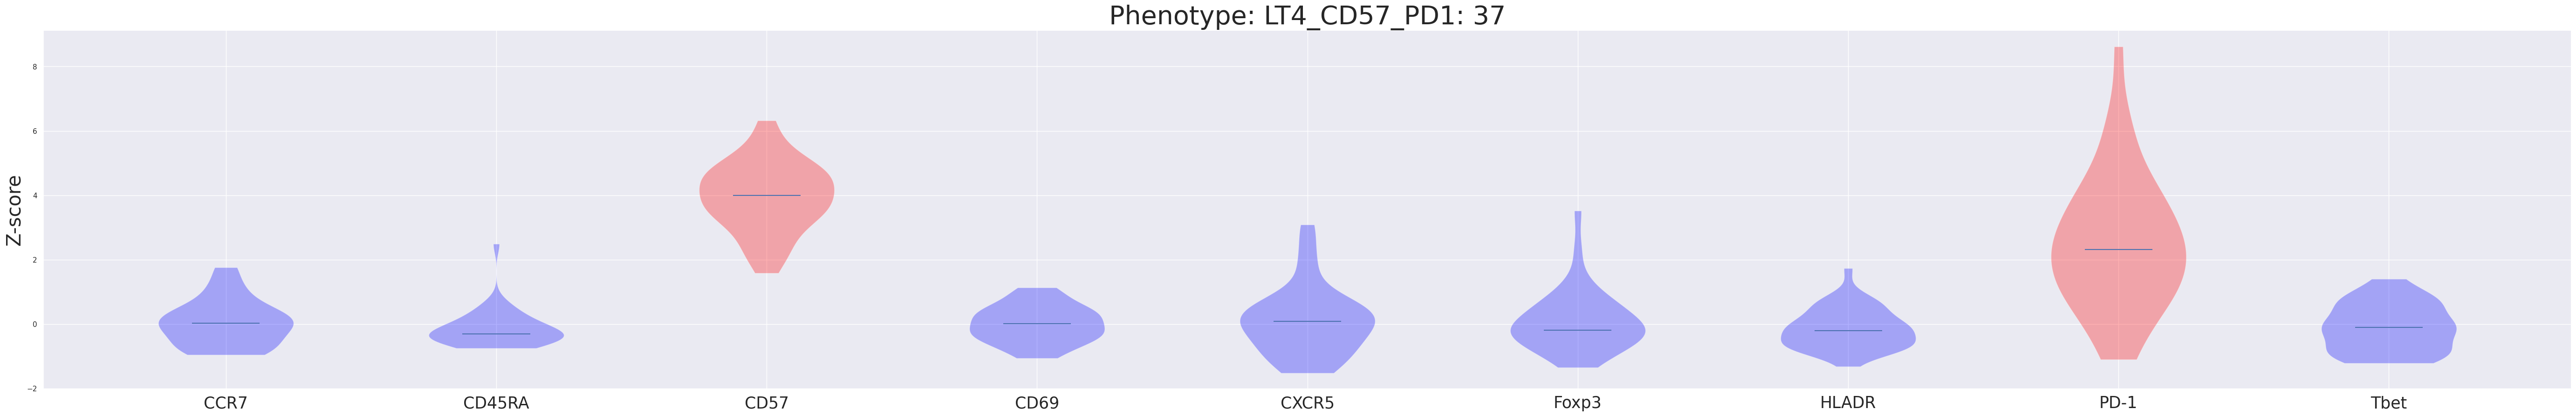

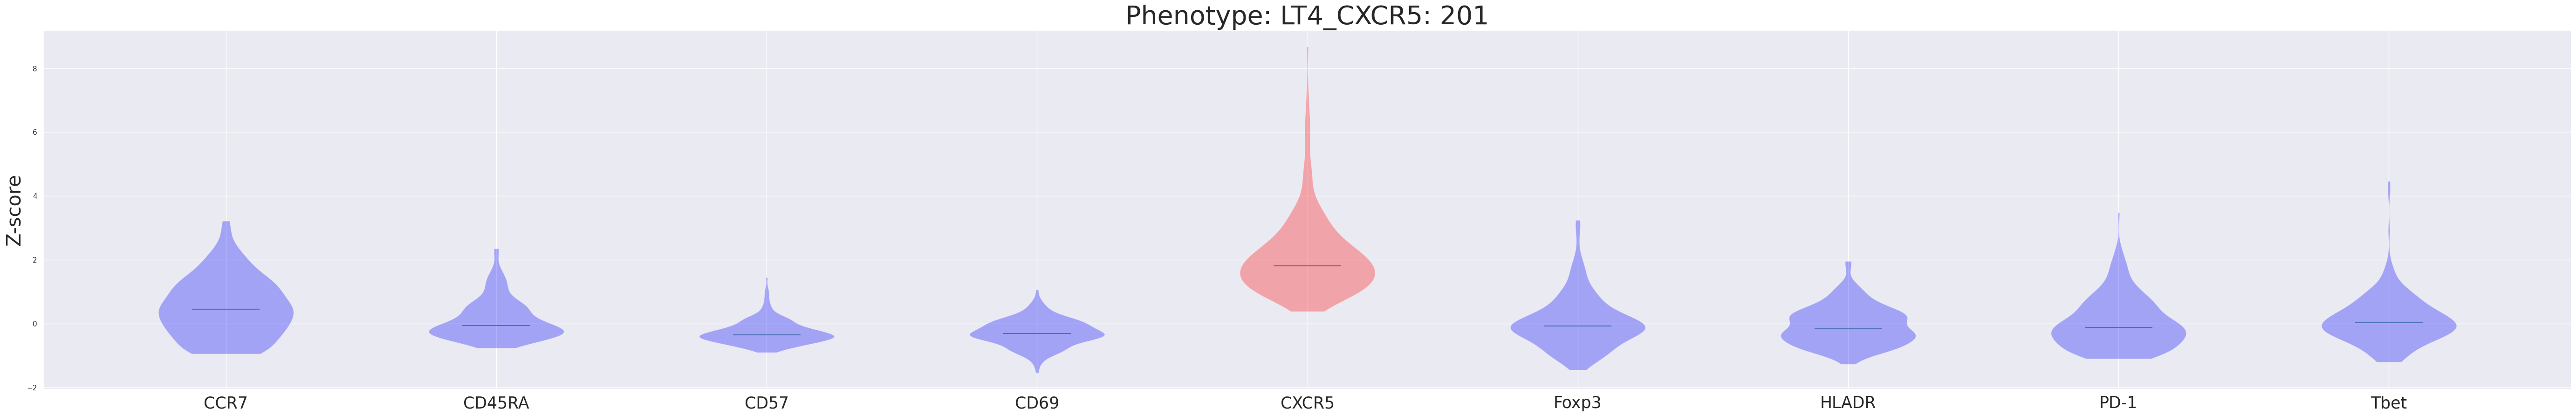

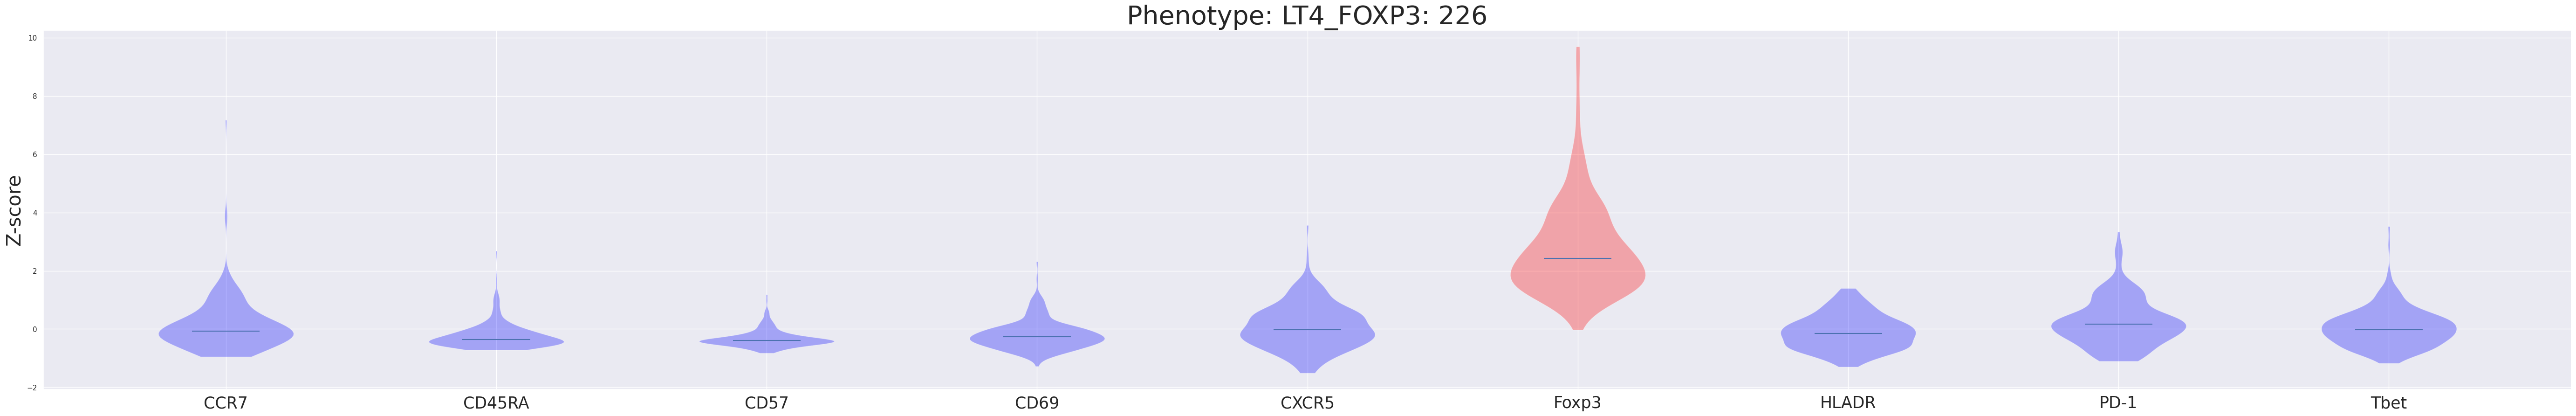

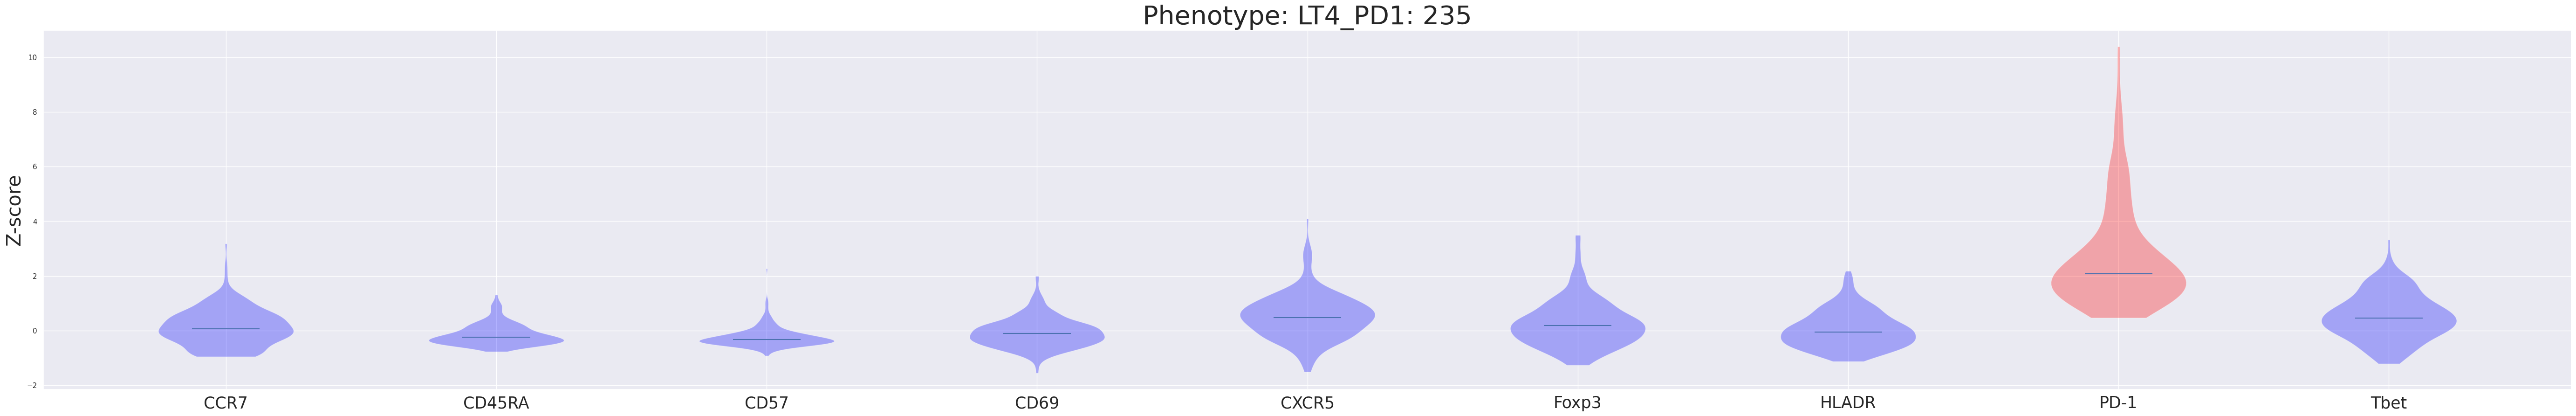

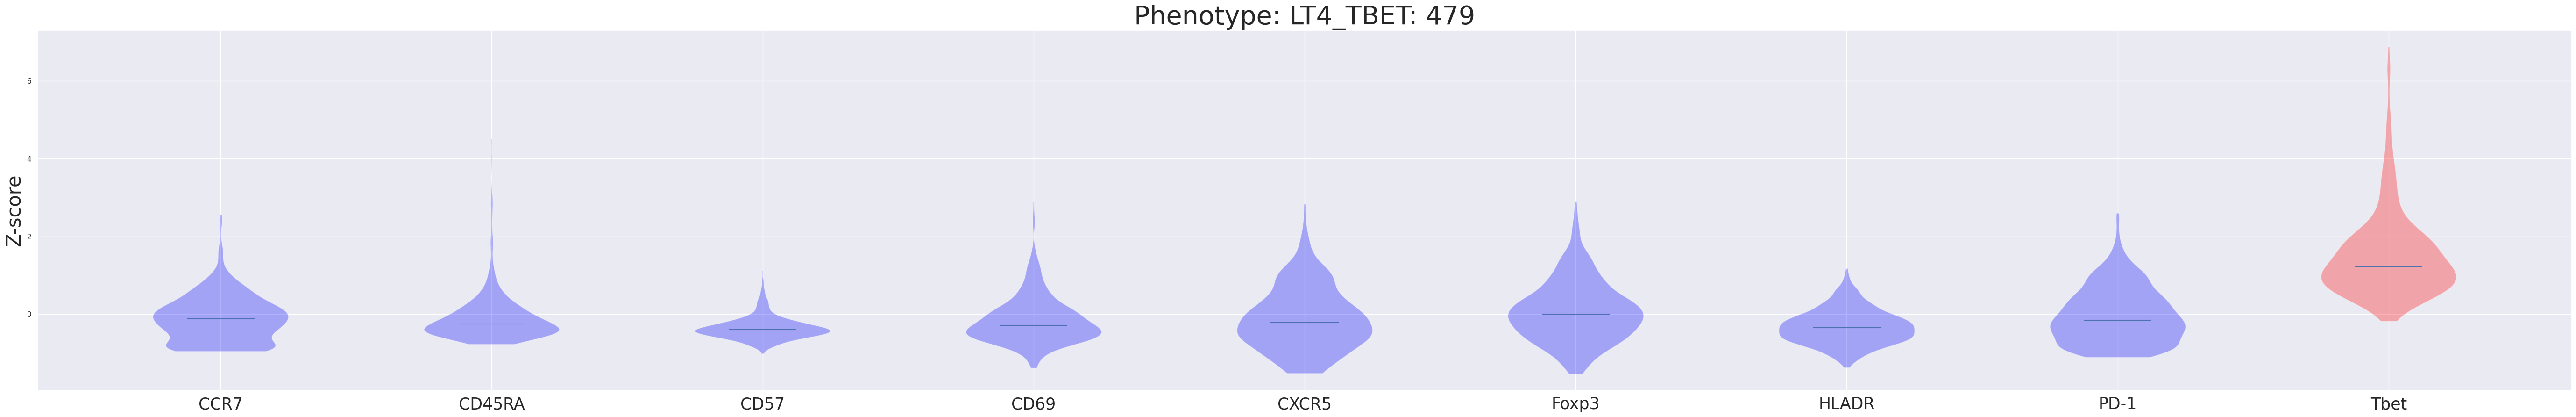

In [ ]:
plot_mfi_pheno(df_subpop_pheno,path_plot_mfi_pheno)

### Representation of the phenotype and the markers belonging to assess the quality of phenotype annotation


#### Functions

In [ ]:
def outline(image, mask, color=(0, 255, 0), thickness=1):
    """
    Draws the contours of objects defined in a numeric (non-binary) mask.

    Args:
        mask (np.ndarray): 2D mask with integer values
                           (e.g., 0 = background, 1, 2, ... = objects).
        image (np.ndarray): Image on which to draw the contours.
                            If None, a black image is created.
        color (tuple): Contour color (in BGR format).
        thickness (int): Contour line thickness.

    Returns:
        np.ndarray: Image with drawn contours.
    """

    if image is None:
        image = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    mask = mask.astype(np.int32)
    objects = np.unique(mask)
    objects = objects[objects != 0]  # Ignore background

    for value in objects:
        # Create a binary mask for the current object
        binary_mask = (mask == value).astype(np.uint8) * 255

        # Find contours
        contours, _ = cv2.findContours(
            binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        # Draw contours
        cv2.drawContours(image, contours, -1, color, thickness)

    return image


In [ ]:

# --- disable matplotlib user warnings (ex: layout, clipping, etc.) ---
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")


def load_image(path):
    try:
        return plt.imread(path)
    except FileNotFoundError:
        print(f"Image not found: {path}")
        return None


def build_mask(df_pheno, roi, pheno, shape):
    mask = np.zeros(shape)
    matches = df_pheno[(df_pheno["ROI"] == roi) & (df_pheno["phenotype"] == pheno)]
    cell_id = 1
    for _, row in matches.iterrows():
        for pixel in row["coord"].split(";")[:-1]:
            x, y = map(int, pixel.split(","))
            mask[x, y] = cell_id
        cell_id += 1
    return mask


def build_mask_color(df_pheno, roi, pheno, shape):
    mask = np.zeros((shape[0], shape[1], 3), dtype=np.uint8)
    matches = df_pheno[(df_pheno["ROI"] == roi) & (df_pheno["phenotype"] == pheno)]
    for _, row in matches.iterrows():
        color = np.random.randint(50, 256, size=3)  # random bright color
        for pixel in row["coord"].split(";")[:-1]:
            x, y = map(int, pixel.split(","))
            mask[x, y] = color
    return mask


def generate_phenotype_image(file, pheno, path_img, path_check, df_pheno, dico_pheno_marker):
    markers = dico_pheno_marker[pheno]
    img_tot = None
    img_shape = None

    # --- load & sum marker images ---
    for marker in markers:
        marker_path = os.path.join(path_img, file, marker + ".png")
        img = load_image(marker_path)
        if img is None:
            continue

        if img_tot is None:
            img_tot = img.copy()
            img_shape = img.shape
        else:
            img_tot += img

    if img_tot is None:
        # nothing loaded for this ROI / phenotype
        return

    img_mask = build_mask(df_pheno, file, pheno, img_shape)
    img_mask_color = build_mask_color(df_pheno, file, pheno, img_shape)

    # layout
    rows, cols = (1, 3) if img_shape[0] * 3 > img_shape[1] else (3, 1)

    fig = plt.figure(figsize=(20, 10))
    plt.subplots_adjust(wspace=0.01, hspace=0.3)

    # 1) summed markers
    plt.subplot(rows, cols, 1)
    plt.imshow(np.arcsinh(img_tot * 10), cmap="gray")
    plt.axis("off")
    plt.title(" + ".join(markers))

    # 2) colored mask (one color per cell)
    plt.subplot(rows, cols, 2)
    plt.imshow(img_mask_color)
    plt.axis("off")
    plt.title(pheno)

    # 3) outline overlay (outline() is assumed to be defined elsewhere)
    plt.subplot(rows, cols, 3)
    plt.imshow(outline(np.arcsinh(img_tot * 10), img_mask, [0, 255, 0], 1))
    plt.axis("off")
    plt.title(str(markers))

    # save
    save_dir = os.path.join(path_check, pheno)
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"{file}.png")

    plt.savefig(save_path, bbox_inches="tight", pad_inches=0)
    plt.close(fig)


def process_all(path_img, path_check, df_pheno, dico_pheno_marker):
    files = sorted(os.listdir(path_img))

    # progress over ROIs
    for file in tqdm(files, desc="ROIs", unit="ROI"):
        # progress over phenotypes for this ROI
        for pheno in tqdm(dico_pheno_marker.keys(),
                          desc=f"Phenotypes for {file}",
                          unit="pheno",
                          leave=False):
            output_path = os.path.join(path_check, pheno, f"{file}.png")
            if not os.path.isfile(output_path):
                generate_phenotype_image(
                    file=file,
                    pheno=pheno,
                    path_img=path_img,
                    path_check=path_check,
                    df_pheno=df_pheno,
                    dico_pheno_marker=dico_pheno_marker,
                )
    print(f"✅ The representation of {pheno} subpopulations on the biopsies can be found in the following folder:  {path_check}")


#### Execution

In [ ]:
path_check=path_subpop+"check_pheno/"
path_img=path+"images/arcsinh_threshold_roi"
if os.path.isdir(path_check)==False:
  os.mkdir(path_check)

In [ ]:
df_subpop_pheno=pd.read_csv(path_subpop+"df_"+pheno+"_subpopulations.csv")
df_subpop_pheno.head()

Unnamed: 0     HLADR    CD45RA      CD69     Foxp3      PD-1      CCR7  \
0           0  0.379393  0.776029 -0.296844 -0.124624 -0.855866  0.349559   
1           1 -0.533756 -0.081900 -0.282423  0.131361  0.882198  0.713513   
2           2 -0.280085 -0.742098 -0.629219 -0.686033 -0.115305 -0.846396   
3           3 -0.217788  0.607424 -0.269207  0.785096 -0.115305  1.146757   
4           4 -0.503085 -0.081900 -0.770386 -0.692139 -0.855866 -0.846396   

       CD57      Tbet     CXCR5         ROI  \
0 -0.403489  0.185720  0.450745  20U03813 a   
1 -0.334773  0.510867  0.572436  20U03813 a   
2  0.918152  0.185720 -0.015882  20U03813 a   
3 -0.415324  0.007631 -0.482676  20U03813 a   
4 -0.788043  2.597996 -0.036175  20U03813 a   

                                               coord  Cell_ID  cluster  \
0  40,449;40,450;40,451;41,448;41,449;41,450;41,4...      119        8   
1  49,0;49,1;49,2;49,3;50,0;50,1;50,2;50,3;50,4;5...      143        1   
2  63,130;63,131;63,132;64,129;64,130;64,131;64,1...      191        1   
3  68,350;68,351;68,352;68,353;69,348;69,349;69,3...      208        1   
4  73,450;73,451;73,452;74,449;74,450;74,451;74,4...      226        2   

    phenotype  
0  LT4_CD45RA  
1         LT4  
2         LT4  
3         LT4  
4    LT4_TBET

In [ ]:
dico_pheno_marker={}
for p in np.unique(df_subpop_pheno["phenotype"]):
  list_marker=input("Enter the markers present in "+p+"(separated by a comma): ").split(",")
  dico_pheno_marker[p]=list_marker

Enter the markers present in LT4(separated by a comma): CD4
Enter the markers present in LT4_CCR7(separated by a comma): CCR7
Enter the markers present in LT4_CD45RA(separated by a comma): CD45RA
Enter the markers present in LT4_CD57_PD1(separated by a comma): CD57,PD-1
Enter the markers present in LT4_CXCR5(separated by a comma): CXCR5
Enter the markers present in LT4_FOXP3(separated by a comma): Foxp3
Enter the markers present in LT4_PD1(separated by a comma): PD-1
Enter the markers present in LT4_TBET(separated by a comma): Tbet


In [ ]:

for pheno in dico_pheno_marker:
    if os.path.isdir(os.path.join(path_check, pheno)) == False:
        os.mkdir(os.path.join(path_check, pheno))

# Appelle la fonction principale ici :
process_all(path_img, path_check, df_subpop_pheno,dico_pheno_marker)


ROIs:   0%|          | 0/23 [00:00<?, ?ROI/s]

Phenotypes for 19U08731 a:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 19U08731 b:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 19U08731 c:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 19U08731 d:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 19U08731 e:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 19U08731 f:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 19U08731 g:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 20U03813 a:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 20U03813 b:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 20U03813 c:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 20U09477 a:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 20U09477 b:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 20U09477 c:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 21U01570 a:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 21U01570 b:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 21U01570 c:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 21U01570 d:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 21U01570 e:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 21U01570 f:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 21U01570 g:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 21U02147 a:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 21U05395 a:   0%|          | 0/8 [00:00<?, ?pheno/s]

Phenotypes for 21U05395 b:   0%|          | 0/8 [00:00<?, ?pheno/s]